In [2]:
import torch
import torchvision

# Get torch version
torch_version = torch.__version__

# Get device name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"

# Get torchvision version
torchvision_version = torchvision.__version__

print(f"torch_version: {torch_version}")
print(f"Device: {device}")
print(f"Device Name: {device_name}")
print(f"Torchvision Version: {torchvision_version}")


torch_version: 2.5.1
Device: cpu
Device Name: CPU
Torchvision Version: 0.20.1


# 1 Model updated with ASPP

In [4]:
# this code is mostly borrowed from DLStudio

import torch.optim as optim
import torch
import torch.nn as nn
import copy
import time
import gzip
import pickle
import numpy as np
import os
import sys
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F


class DLStudio(object):
    def __init__(self, *args, **kwargs ):
        if args:
            raise ValueError(  
                   '''DLStudio constructor can only be called with keyword arguments for 
                      the following keywords: epochs, learning_rate, batch_size, momentum,
                      convo_layers_config, image_size, dataroot, path_saved_model, classes, 
                      image_size, convo_layers_config, fc_layers_config, debug_train, use_gpu, and 
                      debug_test''')
        learning_rate = epochs = batch_size = convo_layers_config = momentum = None
        image_size = fc_layers_config = dataroot =  path_saved_model = classes = use_gpu = None
        debug_train  = debug_test = None
        if 'dataroot' in kwargs                      :   dataroot = kwargs.pop('dataroot')
        if 'learning_rate' in kwargs                 :   learning_rate = kwargs.pop('learning_rate')
        if 'momentum' in kwargs                      :   momentum = kwargs.pop('momentum')
        if 'epochs' in kwargs                        :   epochs = kwargs.pop('epochs')
        if 'batch_size' in kwargs                    :   batch_size = kwargs.pop('batch_size')
        if 'convo_layers_config' in kwargs           :   convo_layers_config = kwargs.pop('convo_layers_config')
        if 'image_size' in kwargs                    :   image_size = kwargs.pop('image_size')
        if 'fc_layers_config' in kwargs              :   fc_layers_config = kwargs.pop('fc_layers_config')
        if 'path_saved_model' in kwargs              :   path_saved_model = kwargs.pop('path_saved_model')
        if 'classes' in kwargs                       :   classes = kwargs.pop('classes') 
        if 'use_gpu' in kwargs                       :   use_gpu = kwargs.pop('use_gpu') 
        if 'debug_train' in kwargs                   :   debug_train = kwargs.pop('debug_train') 
        if 'debug_test' in kwargs                    :   debug_test = kwargs.pop('debug_test') 
        if len(kwargs) != 0: raise ValueError('''You have provided unrecognizable keyword args''')
        if dataroot:
            self.dataroot = dataroot
        if convo_layers_config:
            self.convo_layers_config = convo_layers_config
        if image_size:
            self.image_size = image_size
        if fc_layers_config:
            self.fc_layers_config = fc_layers_config
            if fc_layers_config[0] != -1:
                raise Exception("""\n\n\nYour 'fc_layers_config' construction option is not correct. """
                                """The first element of the list of nodes in the fc layer must be -1 """
                                """because the input to fc will be set automatically to the size of """
                                """the final activation volume of the convolutional part of the network""")
        if  path_saved_model:
            self.path_saved_model = path_saved_model
        if classes:
            self.class_labels = classes
        if learning_rate:
            self.learning_rate = learning_rate
        else:
            self.learning_rate = 1e-6
        if momentum:
            self.momentum = momentum
        if epochs:
            self.epochs = epochs
        if batch_size:
            self.batch_size = batch_size
        if use_gpu is not None:
            self.use_gpu = use_gpu
            if use_gpu is True:
                if torch.cuda.is_available():
                    self.device = torch.device("cuda:0")
                else: 
                    self.device = torch.device("cpu")
        else:
            self.device = torch.device("cpu")
        if debug_train:                             
            self.debug_train = debug_train
        else:
            self.debug_train = 0
        if debug_test:                             
            self.debug_test = debug_test
        else:
            self.debug_test = 0
        self.debug_config = 0


    def imshow(self, img):
        '''
        called by display_tensor_as_image() for displaying the image
        '''
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    
    def dice_loss(preds: torch.Tensor, ground_truth: torch.Tensor):
        # prevents division by zero
        epsilon=1e-6

        # Step 1: Compute Dice Coefficient.
        # For the numerator, multiply the prediction with the ground truth and compute 
        # the sum of elements(in H and W dimensions).
        # shape of preds and ground_truth is (N, C, H, W), so dim 1, 2, 3 are C, H, W
        # we want to sum over C, H, W dimensions so that we aggregate the loss across 
        # all object classes (global dice loss. MSE do the samething)
        numerator = torch.sum(preds * ground_truth, dim=(1, 2, 3)) 

        # For the denominator,  multiply prediction with
        # itself and sum the elements(in H and W dimensions) and multiply ground
        # truth by itself and sum the elements(in H and W dimensions).
        denominator = torch.sum(preds ** 2, dim=(1, 2, 3)) + torch.sum(ground_truth ** 2, dim=(1, 2, 3))

        # Step 2: dice_coeffecient = 2 * numerator / (denominator + epsilon)
        dice_coefficient = 2 * numerator / (denominator + epsilon)

        # Step 3: Compute dice_loss = 1 - dice_coefficient
        dice_loss = 1 - dice_coefficient.mean()

        return dice_loss

    def display_tensor_as_image(self, tensor, title=""):
        '''
        This method converts the argument tensor into a photo image that you can display
        in your terminal screen. It can convert tensors of three different shapes
        into images: (3,H,W), (1,H,W), and (H,W), where H, for height, stands for the
        number of pixels in the vertical direction and W, for width, for the same
        along the horizontal direction.  When the first element of the shape is 3,
        that means that the tensor represents a color image in which each pixel in
        the (H,W) plane has three values for the three color channels.  On the other
        hand, when the first element is 1, that stands for a tensor that will be
        shown as a grayscale image.  And when the shape is just (H,W), that is
        automatically taken to be for a grayscale image.
        '''
        tensor_range = (torch.min(tensor).item(), torch.max(tensor).item())
        if tensor_range == (-1.0,1.0):
            ##  The tensors must be between 0.0 and 1.0 for the display:
            print("\n\n\nimage un-normalization called")
            tensor = tensor/2.0 + 0.5     # unnormalize
        plt.figure(title)
        ###  The call to plt.imshow() shown below needs a numpy array. We must also
        ###  transpose the array so that the number of channels (the same thing as the
        ###  number of color planes) is in the last element.  For a tensor, it would be in
        ###  the first element.
        if tensor.shape[0] == 3 and len(tensor.shape) == 3:
#            plt.imshow( tensor.numpy().transpose(1,2,0) )
            plt.imshow( tensor.numpy().transpose(1,2,0) )
        ###  If the grayscale image was produced by calling torchvision.transform's
        ###  ".ToPILImage()", and the result converted to a tensor, the tensor shape will
        ###  again have three elements in it, however the first element that stands for
        ###  the number of channels will now be 1
        elif tensor.shape[0] == 1 and len(tensor.shape) == 3:
            tensor = tensor[0,:,:]
            plt.imshow( tensor.numpy(), cmap = 'gray' )
        ###  For any one color channel extracted from the tensor representation of a color
        ###  image, the shape of the tensor will be (W,H):
        elif len(tensor.shape) == 2:
            plt.imshow( tensor.numpy(), cmap = 'gray' )
        else:
            sys.exit("\n\n\nfrom 'display_tensor_as_image()': tensor for image is ill formed -- aborting")
        plt.show()




    class SemanticSegmentation(nn.Module):             
        """
        The purpose of this inner class is to be able to use the DLStudio platform for
        experiments with semantic segmentation.  At its simplest level, the purpose of
        semantic segmentation is to assign correct labels to the different objects in a
        scene, while localizing them at the same time.  At a more sophisticated level, a
        system that carries out semantic segmentation should also output a symbolic
        expression based on the objects found in the image and their spatial relationships
        with one another.

        The workhorse of this inner class is the mUNet network that is based on the UNET
        network that was first proposed by Ronneberger, Fischer and Brox in the paper
        "U-Net: Convolutional Networks for Biomedical Image Segmentation".  Their Unet
        extracts binary masks for the cell pixel blobs of interest in biomedical images.
        The output of their Unet can therefore be treated as a pixel-wise binary classifier
        at each pixel position.  The mUnet class, on the other hand, is intended for
        segmenting out multiple objects simultaneously form an image. [A weaker reason for
        "Multi" in the name of the class is that it uses skip connections not only across
        the two arms of the "U", but also also along the arms.  The skip connections in the
        original Unet are only between the two arms of the U.  In mUnet, each object type is
        assigned a separate channel in the output of the network.

        This version of DLStudio also comes with a new dataset, PurdueShapes5MultiObject,
        for experimenting with mUnet.  Each image in this dataset contains a random number
        of selections from five different shapes, with the shapes being randomly scaled,
        oriented, and located in each image.  The five different shapes are: rectangle,
        triangle, disk, oval, and star.

           Class Path:   DLStudio  ->  SemanticSegmentation
        """
        def __init__(self, dl_studio, max_num_objects, dataserver_train=None, dataserver_test=None, dataset_file_train=None, dataset_file_test=None):
            super(DLStudio.SemanticSegmentation, self).__init__()
            self.dl_studio = dl_studio
            self.max_num_objects = max_num_objects
            self.dataserver_train = dataserver_train
            self.dataserver_test = dataserver_test


        class PurdueShapes5MultiObjectDataset(torch.utils.data.Dataset):
            """
            The very first thing to note is that the images in the dataset
            PurdueShapes5MultiObjectDataset are of size 64x64.  Each image has a random
            number (up to five) of the objects drawn from the following five shapes:
            rectangle, triangle, disk, oval, and star.  Each shape is randomized with
            respect to all its parameters, including those for its scale and location in the
            image.

            Each image in the dataset is represented by two data objects, one a list and the
            other a dictionary. The list data objects consists of the following items:

                [R, G, B, mask_array, mask_val_to_bbox_map]                                   ## (A)
            
            and the other data object is a dictionary that is set to:
            
                label_map = {'rectangle':50, 
                             'triangle' :100, 
                             'disk'     :150, 
                             'oval'     :200, 
                             'star'     :250}                                                 ## (B)
            
            Note that that second data object for each image is the same, as shown above.

            In the rest of this comment block, I'll explain in greater detail the elements
            of the list in line (A) above.

            
            R,G,B:
            ------

            Each of these is a 4096-element array whose elements store the corresponding
            color values at each of the 4096 pixels in a 64x64 image.  That is, R is a list
            of 4096 integers, each between 0 and 255, for the value of the red component of
            the color at each pixel. Similarly, for G and B.
            

            mask_array:
            ----------

            The fourth item in the list shown in line (A) above is for the mask which is a
            numpy array of shape:
            
                           (5, 64, 64)
            
            It is initialized by the command:
            
                 mask_array = np.zeros((5,64,64), dtype=np.uint8)
            
            In essence, the mask_array consists of five planes, each of size 64x64.  Each
            plane of the mask array represents an object type according to the following
            shape_index
            
                    shape_index = (label_map[shape] - 50) // 50
            
            where the label_map is as shown in line (B) above.  In other words, the
            shape_index values for the different shapes are:
            
                     rectangle:  0
                      triangle:  1
                          disk:  2
                          oval:  3
                          star:  4
            
            Therefore, the first layer (of index 0) of the mask is where the pixel values of
            50 are stored at all those pixels that belong to the rectangle shapes.
            Similarly, the second mask layer (of index 1) is where the pixel values of 100
            are stored at all those pixel coordinates that belong to the triangle shapes in
            an image; and so on.
            
            It is in the manner described above that we define five different masks for an
            image in the dataset.  Each mask is for a different shape and the pixel values
            at the nonzero pixels in each mask layer are keyed to the shapes also.
            
            A reader is likely to wonder as to the need for this redundancy in the dataset
            representation of the shapes in each image.  Such a reader is likely to ask: Why
            can't we just use the binary values 1s and 0s in each mask layer where the
            corresponding pixels are in the image?  Setting these mask values to 50, 100,
            etc., was done merely for convenience.  I went with the intuition that the
            learning needed for multi-object segmentation would become easier if each shape
            was represented by a different pixels value in the corresponding mask. So I went
            ahead incorporated that in the dataset generation program itself.

            The mask values for the shapes are not to be confused with the actual RGB values
            of the pixels that belong to the shapes. The RGB values at the pixels in a shape
            are randomly generated.  Yes, all the pixels in a shape instance in an image
            have the same RGB values (but that value has nothing to do with the values given
            to the mask pixels for that shape).
            
            
            mask_val_to_bbox_map:
            --------------------
                   
            The fifth item in the list in line (A) above is a dictionary that tells us what
            bounding-box rectangle to associate with each shape in the image.  To illustrate
            what this dictionary looks like, assume that an image contains only one
            rectangle and only one disk, the dictionary in this case will look like:
            
                mask values to bbox mappings:  {200: [], 
                                                250: [], 
                                                100: [], 
                                                 50: [[56, 20, 63, 25]], 
                                                150: [[37, 41, 55, 59]]}
            
            Should there happen to be two rectangles in the same image, the dictionary would
            then be like:
            
                mask values to bbox mappings:  {200: [], 
                                                250: [], 
                                                100: [], 
                                                 50: [[56, 20, 63, 25], [18, 16, 32, 36]], 
                                                150: [[37, 41, 55, 59]]}
            
            Therefore, it is not a problem even if all the objects in an image are of the
            same type.  Remember, the object that are selected for an image are shown
            randomly from the different shapes.  By the way, an entry like '[56, 20, 63,
            25]' for the bounding box means that the upper-left corner of the BBox for the
            'rectangle' shape is at (56,20) and the lower-right corner of the same is at the
            pixel coordinates (63,25).
            
            As far as the BBox quadruples are concerned, in the definition
            
                    [min_x,min_y,max_x,max_y]
            
            note that x is the horizontal coordinate, increasing to the right on your
            screen, and y is the vertical coordinate increasing downwards.

            Class Path:   DLStudio  ->  SemanticSegmentation  ->  PurdueShapes5MultiObjectDataset

            """
            def __init__(self, dl_studio, segmenter, train_or_test, dataset_file):
                super(DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset, self).__init__()
                max_num_objects = segmenter.max_num_objects
                if train_or_test == 'train' and dataset_file == "PurdueShapes5MultiObject-10000-train.gz":
                    if os.path.exists("torch_saved_PurdueShapes5MultiObject-10000_dataset.pt") and \
                              os.path.exists("torch_saved_PurdueShapes5MultiObject_label_map.pt"):
                        print("\nLoading training data from torch saved file")
                        self.dataset = torch.load("torch_saved_PurdueShapes5MultiObject-10000_dataset.pt")
                        self.label_map = torch.load("torch_saved_PurdueShapes5MultiObject_label_map.pt")
                        self.num_shapes = len(self.label_map)
                        self.image_size = dl_studio.image_size
                    else: 
                        print("""\n\n\nLooks like this is the first time you will be loading in\n"""
                              """the dataset for this script. First time loading could take\n"""
                              """a few minutes.  Any subsequent attempts will only take\n"""
                              """a few seconds.\n\n\n""")
                        root_dir = dl_studio.dataroot
                        f = gzip.open(root_dir + dataset_file, 'rb')
                        dataset = f.read()
                        self.dataset, self.label_map = pickle.loads(dataset, encoding='latin1')
                        torch.save(self.dataset, "torch_saved_PurdueShapes5MultiObject-10000_dataset.pt")
                        torch.save(self.label_map, "torch_saved_PurdueShapes5MultiObject_label_map.pt")
                        # reverse the key-value pairs in the label dictionary:
                        self.class_labels = dict(map(reversed, self.label_map.items()))
                        self.num_shapes = len(self.class_labels)
                        self.image_size = dl_studio.image_size
                else:
                    root_dir = dl_studio.dataroot
                    f = gzip.open(root_dir + dataset_file, 'rb')
                    dataset = f.read()
                    if sys.version_info[0] == 3:
                        self.dataset, self.label_map = pickle.loads(dataset, encoding='latin1')
                    else:
                        self.dataset, self.label_map = pickle.loads(dataset)
                    # reverse the key-value pairs in the label dictionary:
                    self.class_labels = dict(map(reversed, self.label_map.items()))
                    self.num_shapes = len(self.class_labels)
                    self.image_size = dl_studio.image_size

            def __len__(self):
                return len(self.dataset)

            def __getitem__(self, idx):
                image_size = self.image_size
                r = np.array( self.dataset[idx][0] )
                g = np.array( self.dataset[idx][1] )
                b = np.array( self.dataset[idx][2] )
                R,G,B = r.reshape(image_size[0],image_size[1]), g.reshape(image_size[0],image_size[1]), b.reshape(image_size[0],image_size[1])
                im_tensor = torch.zeros(3,image_size[0],image_size[1], dtype=torch.float)
                im_tensor[0,:,:] = torch.from_numpy(R)
                im_tensor[1,:,:] = torch.from_numpy(G)
                im_tensor[2,:,:] = torch.from_numpy(B)
                mask_array = np.array(self.dataset[idx][3])
                max_num_objects = len( mask_array[0] ) 
                mask_tensor = torch.from_numpy(mask_array)
                mask_val_to_bbox_map =  self.dataset[idx][4]
                max_bboxes_per_entry_in_map = max([ len(mask_val_to_bbox_map[key]) for key in mask_val_to_bbox_map ])
                ##  The first arg 5 is for the number of bboxes we are going to need. If all the
                ##  shapes are exactly the same, you are going to need five different bbox'es.
                ##  The second arg is the index reserved for each shape in a single bbox
                bbox_tensor = torch.zeros(max_num_objects,self.num_shapes,4, dtype=torch.float)
                for bbox_idx in range(max_bboxes_per_entry_in_map):
                    for key in mask_val_to_bbox_map:
                        if len(mask_val_to_bbox_map[key]) == 1:
                            if bbox_idx == 0:
                                bbox_tensor[bbox_idx,key,:] = torch.from_numpy(np.array(mask_val_to_bbox_map[key][bbox_idx]))
                        elif len(mask_val_to_bbox_map[key]) > 1 and bbox_idx < len(mask_val_to_bbox_map[key]):
                            bbox_tensor[bbox_idx,key,:] = torch.from_numpy(np.array(mask_val_to_bbox_map[key][bbox_idx]))
                sample = {'image'        : im_tensor, 
                          'mask_tensor'  : mask_tensor,
                          'bbox_tensor'  : bbox_tensor }
                return sample

        def load_PurdueShapes5MultiObject_dataset(self, dataserver_train, dataserver_test ):   
            self.train_dataloader = torch.utils.data.DataLoader(dataserver_train,
                        batch_size=self.dl_studio.batch_size,shuffle=True, num_workers=0)
            self.test_dataloader = torch.utils.data.DataLoader(dataserver_test,
                               batch_size=self.dl_studio.batch_size,shuffle=False, num_workers=0)


        class SkipBlockDN(nn.Module):
            """
            This class for the skip connections in the downward leg of the "U"

            Class Path:   DLStudio  ->  SemanticSegmentation  ->  SkipBlockDN
            """
            def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
                super(DLStudio.SemanticSegmentation.SkipBlockDN, self).__init__()
                self.downsample = downsample
                self.skip_connections = skip_connections
                self.in_ch = in_ch
                self.out_ch = out_ch

                # UP is using ConvTranspose2d, DN is using Conv2d
                self.convo1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
                self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)

                self.bn1 = nn.BatchNorm2d(out_ch)
                self.bn2 = nn.BatchNorm2d(out_ch)
                if downsample:
                    # UP is using ConvTranspose2d, DN is using Conv2d
                    self.downsampler = nn.Conv2d(in_ch, out_ch, 1, stride=2)
            def forward(self, x):
                identity = x                                     
                out = self.convo1(x)                              
                out = self.bn1(out)                              
                out = nn.functional.relu(out)
                if self.in_ch == self.out_ch:
                    out = self.convo2(out)                              
                    out = self.bn2(out)                              
                    out = nn.functional.relu(out)
                if self.downsample:
                    out = self.downsampler(out)
                    identity = self.downsampler(identity)
                if self.skip_connections:
                    if self.in_ch == self.out_ch:
                        out = out + identity
                    else:
                        out = out + torch.cat((identity, identity), dim=1) 
                return out


        class SkipBlockUP(nn.Module):
            """
            This class is for the skip connections in the upward leg of the "U"

            Class Path:   DLStudio  ->  SemanticSegmentation  ->  SkipBlockUP
            """
            def __init__(self, in_ch, out_ch, upsample=False, skip_connections=True):
                super(DLStudio.SemanticSegmentation.SkipBlockUP, self).__init__()
                self.upsample = upsample
                self.skip_connections = skip_connections
                self.in_ch = in_ch
                self.out_ch = out_ch

                # DN is using Conv2d, UP is using ConvTranspose2d
                self.convoT1 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)
                self.convoT2 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)

                self.bn1 = nn.BatchNorm2d(out_ch)
                self.bn2 = nn.BatchNorm2d(out_ch)
                if upsample:
                    # DN is using Conv2d, UP is using ConvTranspose2d
                    self.upsampler = nn.ConvTranspose2d(in_ch, out_ch, 1, stride=2, dilation=2, output_padding=1, padding=0)
            def forward(self, x):
                identity = x                                     
                out = self.convoT1(x)                              
                out = self.bn1(out)                              
                out = nn.functional.relu(out)
                out  =  nn.ReLU(inplace=False)(out)            
                if self.in_ch == self.out_ch:
                    out = self.convoT2(out)                              
                    out = self.bn2(out)                              
                    out = nn.functional.relu(out)
                if self.upsample:
                    out = self.upsampler(out)
                    identity = self.upsampler(identity)
                if self.skip_connections:
                    if self.in_ch == self.out_ch:
                        out = out + identity                              
                    else:
                        out = out + identity[:,self.out_ch:,:,:]
                return out
            
        class ASPP(nn.Module):
            """
            This class is for the Atrous Spatial Pyramid Pooling (ASPP) block. The ASPP
            block is used to capture the context information at multiple scales.  The ASPP
            block uses atrous convolutions with different rates to capture context
            information at different scales.  The ASPP block is placed on top of the
            feature extractor network.  The ASPP block uses the original convolutional 
            feature map, the other branches use convolutional feature maps that are obtained by applying 
            atrous convolutions with different rates to the original feature map.  The outputs of
            the three branches are then concatenated and passed through a 1x1 convolutional
            layer to obtain the final output of the ASPP block.
            """
            def __init__(self, in_ch, out_ch):
                super(DLStudio.SemanticSegmentation.ASPP, self).__init__()
                self.conv1 = nn.Conv2d(in_ch, out_ch, 1)

                # padding needs to be eqaul to dilation when kernel size is 3. So that the output size is 
                # same as input size. 
                # (formula: out_size = (in_size + 2*padding - dilation*(kernel_size-1) - 1)/stride + 1)
                self.conv2 = nn.Conv2d(in_ch, out_ch, 3, padding=6, dilation=6) 
                self.conv3 = nn.Conv2d(in_ch, out_ch, 3, padding=12, dilation=12)
                self.conv4 = nn.Conv2d(in_ch, out_ch, 3, padding=18, dilation=18)
                self.conv5 = nn.Conv2d(in_ch, out_ch, 3, padding=24, dilation=24)

                # final conv for concatenation
                self.conv6 = nn.Conv2d(out_ch*5, out_ch, 1)
            def forward(self, x):
                out1 = self.conv1(x)
                out2 = self.conv2(x)
                out3 = self.conv3(x)
                out4 = self.conv4(x)
                out5 = self.conv5(x)
                out = torch.cat([out1, out2, out3, out4, out5], dim=1)
                out = self.conv6(out)
                return out
        

        class mUNet(nn.Module):
            """
            This network is called mUNet because it is intended for segmenting out
            multiple objects simultaneously form an image. [A weaker reason for "Multi" in
            the name of the class is that it uses skip connections not only across the two
            arms of the "U", but also also along the arms.]  The classic UNET was first
            proposed by Ronneberger, Fischer and Brox in the paper "U-Net: Convolutional
            Networks for Biomedical Image Segmentation".  Their UNET extracts binary masks
            for the cell pixel blobs of interest in biomedical images.  The output of their
            UNET therefore can therefore be treated as a pixel-wise binary classifier at
            each pixel position.

            The mUNet presented here, on the other hand, is meant specifically for
            simultaneously identifying and localizing multiple objects in a given image.
            Each object type is assigned a separate channel in the output of the network.

            I have created a dataset, PurdueShapes5MultiObject, for experimenting with
            mUNet.  Each image in this dataset contains a random number of selections from
            five different shapes, with the shapes being randomly scaled, oriented, and
            located in each image.  The five different shapes are: rectangle, triangle,
            disk, oval, and star.

            Class Path:   DLStudio  ->  SemanticSegmentation  ->  mUNet

            """ 
            def __init__(self, skip_connections=True, depth=16):
                super(DLStudio.SemanticSegmentation.mUNet, self).__init__()
                self.depth = depth // 2
                self.conv_in = nn.Conv2d(3, 64, 3, padding=1)
                ##  For the DN(down) arm of the U:
                self.bn1DN  = nn.BatchNorm2d(64)
                self.bn2DN  = nn.BatchNorm2d(128)
                self.skip64DN_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip64DN_arr.append(DLStudio.SemanticSegmentation.SkipBlockDN(64, 64, skip_connections=skip_connections))
                self.skip64dsDN = DLStudio.SemanticSegmentation.SkipBlockDN(64, 64,   downsample=True, skip_connections=skip_connections)
                self.skip64to128DN = DLStudio.SemanticSegmentation.SkipBlockDN(64, 128, skip_connections=skip_connections )
                self.skip128DN_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip128DN_arr.append(DLStudio.SemanticSegmentation.SkipBlockDN(128, 128, skip_connections=skip_connections))
                self.skip128dsDN = DLStudio.SemanticSegmentation.SkipBlockDN(128,128, downsample=True, skip_connections=skip_connections)
                


                # add ASPP block before going up
                self.aspp = DLStudio.SemanticSegmentation.ASPP(128, 128)



                ##  For the UP arm of the U:
                self.bn1UP  = nn.BatchNorm2d(128)
                self.bn2UP  = nn.BatchNorm2d(64)
                self.skip64UP_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip64UP_arr.append(DLStudio.SemanticSegmentation.SkipBlockUP(64, 64, skip_connections=skip_connections))
                self.skip64usUP = DLStudio.SemanticSegmentation.SkipBlockUP(64, 64, upsample=True, skip_connections=skip_connections)
                self.skip128to64UP = DLStudio.SemanticSegmentation.SkipBlockUP(128, 64, skip_connections=skip_connections )
                self.skip128UP_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip128UP_arr.append(DLStudio.SemanticSegmentation.SkipBlockUP(128, 128, skip_connections=skip_connections))
                self.skip128usUP = DLStudio.SemanticSegmentation.SkipBlockUP(128,128, upsample=True, skip_connections=skip_connections)
                self.conv_out = nn.ConvTranspose2d(64, 5, 3, stride=2,dilation=2,output_padding=1,padding=2)

            def forward(self, x):
                ##  Going down to the bottom of the U:
                x = nn.MaxPool2d(2,2)(nn.functional.relu(self.conv_in(x)))          
                for i,skip64 in enumerate(self.skip64DN_arr[:self.depth//4]):
                    x = skip64(x)                
        
                num_channels_to_save1 = x.shape[1] // 2 # x.shape[1] is the number of output channels
                save_for_upside_1 = x[:,:num_channels_to_save1,:,:].clone()
                x = self.skip64dsDN(x)
                for i,skip64 in enumerate(self.skip64DN_arr[self.depth//4:]):
                    x = skip64(x)                
                x = self.bn1DN(x)
                num_channels_to_save2 = x.shape[1] // 2
                save_for_upside_2 = x[:,:num_channels_to_save2,:,:].clone()
                x = self.skip64to128DN(x)
                for i,skip128 in enumerate(self.skip128DN_arr[:self.depth//4]):
                    x = skip128(x)                
        
                x = self.bn2DN(x)
                num_channels_to_save3 = x.shape[1] // 2
                save_for_upside_3 = x[:,:num_channels_to_save3,:,:].clone()
                for i,skip128 in enumerate(self.skip128DN_arr[self.depth//4:]):
                    x = skip128(x)                
                x = self.skip128dsDN(x)



                # add ASPP block beforing going up
                x = self.aspp(x)



                ## Coming up from the bottom of U on the other side:
                x = self.skip128usUP(x)          
                for i,skip128 in enumerate(self.skip128UP_arr[:self.depth//4]):
                    x = skip128(x)                
                x[:,:num_channels_to_save3,:,:] =  save_for_upside_3
                x = self.bn1UP(x)
                for i,skip128 in enumerate(self.skip128UP_arr[:self.depth//4]):
                    x = skip128(x)                
                x = self.skip128to64UP(x)
                for i,skip64 in enumerate(self.skip64UP_arr[self.depth//4:]):
                    x = skip64(x)                
                x[:,:num_channels_to_save2,:,:] =  save_for_upside_2
                x = self.bn2UP(x)
                x = self.skip64usUP(x)
                for i,skip64 in enumerate(self.skip64UP_arr[:self.depth//4]):
                    x = skip64(x)                
                x[:,:num_channels_to_save1,:,:] =  save_for_upside_1
                x = self.conv_out(x)
                return x
        

        class SegmentationLoss(nn.Module):
            """
            I wrote this class before I switched to MSE loss.  I am leaving it here
            in case I need to get back to it in the future.  

            Class Path:   DLStudio  ->  SemanticSegmentation  ->  SegmentationLoss
            """
            def __init__(self, batch_size):
                super(DLStudio.SemanticSegmentation.SegmentationLoss, self).__init__()
                self.batch_size = batch_size
            def forward(self, output, mask_tensor):
                composite_loss = torch.zeros(1,self.batch_size)
                mask_based_loss = torch.zeros(1,5)
                for idx in range(self.batch_size):
                    outputh = output[idx,0,:,:]
                    for mask_layer_idx in range(mask_tensor.shape[0]):
                        mask = mask_tensor[idx,mask_layer_idx,:,:]
                        element_wise = (outputh - mask)**2                   
                        mask_based_loss[0,mask_layer_idx] = torch.mean(element_wise)
                    composite_loss[0,idx] = torch.sum(mask_based_loss)
                return torch.sum(composite_loss) / self.batch_size


        def MSE_run_code_for_training_for_semantic_segmentation(self, net):        
            filename_for_out1 = "performance_numbers_" + str(self.dl_studio.epochs) + ".txt"
            FILE1 = open(filename_for_out1, 'w')
            net = copy.deepcopy(net)
            net = net.to(self.dl_studio.device)

            # using MSE loss
            criterion1 = nn.MSELoss()

            optimizer = optim.SGD(net.parameters(), 
                         lr=self.dl_studio.learning_rate, momentum=self.dl_studio.momentum)
            start_time = time.perf_counter()

            # record the loss values
            total_loss = []

            for epoch in range(self.dl_studio.epochs):  
                print("")
                running_loss_segmentation = 0.0
                for i, data in enumerate(self.train_dataloader):    
                    im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                    im_tensor   = im_tensor.to(self.dl_studio.device)
                    mask_tensor = mask_tensor.type(torch.FloatTensor)
                    mask_tensor = mask_tensor.to(self.dl_studio.device)                 
                    bbox_tensor = bbox_tensor.to(self.dl_studio.device)
                    optimizer.zero_grad()
                    output = net(im_tensor) 
                    segmentation_loss = criterion1(output, mask_tensor)  
                    segmentation_loss.backward()
                    optimizer.step()
                    running_loss_segmentation += segmentation_loss.item()    
                    if i%500==499:    
                        current_time = time.perf_counter()
                        elapsed_time = current_time - start_time
                        avg_loss_segmentation = running_loss_segmentation / float(500)
                        print("[epoch=%d/%d, iter=%4d  elapsed_time=%3d secs]   loss: %.3f" % (epoch+1, self.dl_studio.epochs, i+1, elapsed_time, avg_loss_segmentation))
                        total_loss.append(avg_loss_segmentation)
                        FILE1.write("%.3f\n" % avg_loss_segmentation)
                        FILE1.flush()
                        running_loss_segmentation = 0.0
            print("\nFinished Training\n")
            self.save_model(net)

            return total_loss


        def DICE_run_code_for_training_for_semantic_segmentation(self, net):        
            filename_for_out1 = "performance_numbers_" + str(self.dl_studio.epochs) + ".txt"
            FILE1 = open(filename_for_out1, 'w')
            net = copy.deepcopy(net)
            net = net.to(self.dl_studio.device)

            optimizer = optim.SGD(net.parameters(), 
                         lr=self.dl_studio.learning_rate, momentum=self.dl_studio.momentum)
            start_time = time.perf_counter()

            # record the loss values
            total_loss = []

            for epoch in range(self.dl_studio.epochs):  
                print("")
                running_loss_segmentation = 0.0
                for i, data in enumerate(self.train_dataloader):    
                    im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                    im_tensor   = im_tensor.to(self.dl_studio.device)
                    mask_tensor = mask_tensor.type(torch.FloatTensor)
                    mask_tensor = mask_tensor.to(self.dl_studio.device)                 
                    bbox_tensor = bbox_tensor.to(self.dl_studio.device)
                    optimizer.zero_grad()
                    output = net(im_tensor) 

                    # using DICE loss
                    segmentation_loss = DLStudio.dice_loss(output, mask_tensor)

                    segmentation_loss.backward()
                    optimizer.step()
                    running_loss_segmentation += segmentation_loss.item()    
                    if i%500==499:    
                        current_time = time.perf_counter()
                        elapsed_time = current_time - start_time
                        avg_loss_segmentation = running_loss_segmentation / float(500)
                        print("[epoch=%d/%d, iter=%4d  elapsed_time=%3d secs]   MSE loss: %.3f" % (epoch+1, self.dl_studio.epochs, i+1, elapsed_time, avg_loss_segmentation))
                        total_loss.append(avg_loss_segmentation)
                        FILE1.write("%.3f\n" % avg_loss_segmentation)
                        FILE1.flush()
                        running_loss_segmentation = 0.0
            print("\nFinished Training\n")
            self.save_model(net)
            return total_loss
        

        def DICE_MSE_run_code_for_training_for_semantic_segmentation(self, net, DiceScale):
            filename_for_out1 = "performance_numbers_" + str(self.dl_studio.epochs) + ".txt"
            FILE1 = open(filename_for_out1, 'w')
            net = copy.deepcopy(net)
            net = net.to(self.dl_studio.device)

            optimizer = optim.SGD(net.parameters(), 
                         lr=self.dl_studio.learning_rate, momentum=self.dl_studio.momentum)
            start_time = time.perf_counter()

            # record the loss values
            total_loss = []

            for epoch in range(self.dl_studio.epochs):  
                print("")
                running_loss_segmentation = 0.0
                for i, data in enumerate(self.train_dataloader):    
                    im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                    im_tensor   = im_tensor.to(self.dl_studio.device)
                    mask_tensor = mask_tensor.type(torch.FloatTensor)
                    mask_tensor = mask_tensor.to(self.dl_studio.device)                 
                    bbox_tensor = bbox_tensor.to(self.dl_studio.device)
                    optimizer.zero_grad()
                    output = net(im_tensor) 



                    # using DICE+MSE loss
                    dice_scale = DiceScale
                    segmentation_loss = dice_scale * DLStudio.dice_loss(output, mask_tensor)
                    segmentation_loss += nn.MSELoss()(output, mask_tensor)



                    segmentation_loss.backward()
                    optimizer.step()
                    running_loss_segmentation += segmentation_loss.item()    
                    if i%500==499:    
                        current_time = time.perf_counter()
                        elapsed_time = current_time - start_time
                        avg_loss_segmentation = running_loss_segmentation / float(500)
                        print("[epoch=%d/%d, iter=%4d  elapsed_time=%3d secs]   MSE loss: %.3f" % (epoch+1, self.dl_studio.epochs, i+1, elapsed_time, avg_loss_segmentation))
                        total_loss.append(avg_loss_segmentation)
                        FILE1.write("%.3f\n" % avg_loss_segmentation)
                        FILE1.flush()
                        running_loss_segmentation = 0.0
            print("\nFinished Training\n")
            self.save_model(net)
            return total_loss


        def save_model(self, model):
            '''
            Save the trained model to a disk file
            '''
            torch.save(model.state_dict(), self.dl_studio.path_saved_model)


        def run_code_for_testing_semantic_segmentation(self, net):
            net.load_state_dict(torch.load(self.dl_studio.path_saved_model))
            batch_size = self.dl_studio.batch_size
            image_size = self.dl_studio.image_size
            max_num_objects = self.max_num_objects
            with torch.no_grad():
                for i, data in enumerate(self.test_dataloader):
                    im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                    if i % 50 == 0:
                        print("Showing output for test batch %d: " % (i+1))
                        outputs = net(im_tensor)                        
                        ## In the statement below: 1st arg for batch items, 2nd for channels, 3rd and 4th for image size
                        output_bw_tensor = torch.zeros(batch_size,1,image_size[0],image_size[1], dtype=float)
                        for image_idx in range(batch_size):
                            for layer_idx in range(max_num_objects): 
                                for m in range(image_size[0]):
                                    for n in range(image_size[1]):
                                        output_bw_tensor[image_idx,0,m,n]  =  torch.max( outputs[image_idx,:,m,n] )
                        display_tensor = torch.zeros(7 * batch_size,3,image_size[0],image_size[1], dtype=float)
                        for idx in range(batch_size):
                            for bbox_idx in range(max_num_objects):   
                                bb_tensor = bbox_tensor[idx,bbox_idx]
                                for k in range(max_num_objects):
                                    i1 = int(bb_tensor[k][1])
                                    i2 = int(bb_tensor[k][3])
                                    j1 = int(bb_tensor[k][0])
                                    j2 = int(bb_tensor[k][2])
                                    output_bw_tensor[idx,0,i1:i2,j1] = 255
                                    output_bw_tensor[idx,0,i1:i2,j2] = 255
                                    output_bw_tensor[idx,0,i1,j1:j2] = 255
                                    output_bw_tensor[idx,0,i2,j1:j2] = 255
                                    im_tensor[idx,0,i1:i2,j1] = 255
                                    im_tensor[idx,0,i1:i2,j2] = 255
                                    im_tensor[idx,0,i1,j1:j2] = 255
                                    im_tensor[idx,0,i2,j1:j2] = 255
                        display_tensor[:batch_size,:,:,:] = output_bw_tensor
                        display_tensor[batch_size:2*batch_size,:,:,:] = im_tensor

                        for batch_im_idx in range(batch_size):
                            for mask_layer_idx in range(max_num_objects):
                                for i in range(image_size[0]):
                                    for j in range(image_size[1]):
                                        if mask_layer_idx == 0:
                                            if 25 < outputs[batch_im_idx,mask_layer_idx,i,j] < 85:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                            else:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                        elif mask_layer_idx == 1:
                                            if 65 < outputs[batch_im_idx,mask_layer_idx,i,j] < 135:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                            else:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                        elif mask_layer_idx == 2:
                                            if 115 < outputs[batch_im_idx,mask_layer_idx,i,j] < 185:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                            else:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                        elif mask_layer_idx == 3:
                                            if 165 < outputs[batch_im_idx,mask_layer_idx,i,j] < 230:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                            else:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                        elif mask_layer_idx == 4:
                                            if outputs[batch_im_idx,mask_layer_idx,i,j] > 210:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                            else:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 50

                                display_tensor[2*batch_size+batch_size*mask_layer_idx+batch_im_idx,:,:,:]= outputs[batch_im_idx,mask_layer_idx,:,:]
                        self.dl_studio.display_tensor_as_image(
                           torchvision.utils.make_grid(display_tensor, nrow=batch_size, normalize=True, padding=2, pad_value=10))




        def compute_iou(self, pred_mask, true_mask):
            intersection = (pred_mask & true_mask).sum()
            union = (pred_mask | true_mask).sum()
            return intersection / union if union > 0 else 0  # Avoid division by zero

        def run_code_for_compute_iou(self, net):
            net.load_state_dict(torch.load(self.dl_studio.path_saved_model))
            net.eval()  # Set model to evaluation mode
            total_iou = 0
            total_accuracy = 0
            num_samples = 0

            with torch.no_grad():
                for i, data in enumerate(self.test_dataloader):
                    im_tensor, mask_tensor = data['image'], data['mask_tensor']
                    outputs = net(im_tensor)

                    # Convert outputs to binary masks. (B,C,H,W) -> (B,H,W). 
                    # Each pixel is assigned the class index with the highest predicted probability.
                    pred_masks = outputs.argmax(dim=1) 
                    true_masks = mask_tensor.argmax(dim=1) 

                    # Compute IoU for each image in batch
                    for j in range(pred_masks.shape[0]):
                        iou = self.compute_iou(pred_masks[j] > 0.5, true_masks[j] > 0.5) # Binarize mask is shape of (height, width)
                        total_iou += iou

                        # get same pixel for accuracy
                        correct_pixels = (pred_masks[j] == true_masks[j]).sum()
                        total_pixels = true_masks[j].numel()
                        total_accuracy += correct_pixels / total_pixels

                        num_samples += 1

            mean_iou = total_iou / num_samples
            mean_accuracy = total_accuracy / num_samples
            print(f"Mean IoU: {mean_iou:.4f}, Mean Pixel Accuracy: {mean_accuracy:.4f}")



##### Understanding of mUnet
mUNet is a modified version of the U-Net architecture designed for multi-object semantic segmentation. It follows the typical encoder-decoder structure, where the encoder extracts hierarchical features, and the decoder reconstructs segmented objects. Skip connections are used throughout to preserve spatial details and improve learning efficiency. A key enhancement in mUNet is the Atrous Spatial Pyramid Pooling (ASPP) block, which captures multi-scale context by applying dilated convolutions at different rates. This helps in segmenting objects of various sizes effectively. 

##### When using Dice+MSE loss, do you think there should be a scaling factor to scale the Dice Loss? Why or Why not?

I think there should be a scaling factor to scale the Dice Loss because Dice loss is typically bounded—usually falling between 0 and 1 - whereas MSE loss can vary widely and reach much larger values. Without scaling, the MSE component might dominate the combined loss, which could cause the optimization to prioritize reducing MSE error over improving the overlap measure that Dice loss provides.


# 2 Training best curves

## 2.1 MSE loss curve

In [5]:

dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/PurdueShapes5MultiObject/",
                    dataroot = "./../data/datasets_for_DLStudio/data/",
                    image_size = [64,64],
                    path_saved_model = "./saved_model_MSE",
                    momentum = 0.9,
                    learning_rate = 1e-4,
                    epochs = 6,
                    batch_size = 4,
                    classes = ('rectangle','triangle','disk','oval','star'),
                    use_gpu = True,
                )

segmenter = DLStudio.SemanticSegmentation( 
                    dl_studio = dls, 
                    max_num_objects = 5,
                )

dataserver_train = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                            train_or_test = 'train',
                            dl_studio = dls,
                            segmenter = segmenter,
                            dataset_file = "PurdueShapes5MultiObject-10000-train.gz", 
                        )
dataserver_test = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                            train_or_test = 'test',
                            dl_studio = dls,
                            segmenter = segmenter,
                            dataset_file = "PurdueShapes5MultiObject-1000-test.gz"
                        )
segmenter.dataserver_train = dataserver_train
segmenter.dataserver_test = dataserver_test

segmenter.load_PurdueShapes5MultiObject_dataset(dataserver_train, dataserver_test)

model = segmenter.mUNet(skip_connections=True, depth=16)
#model = segmenter.mUNet(skip_connections=False, depth=4)

number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The number of learnable parameters in the model: %d\n" % number_of_learnable_params)

MSELoss = segmenter.MSE_run_code_for_training_for_semantic_segmentation(model)

segmenter.run_code_for_testing_semantic_segmentation(model)

plt.figure(figsize=(10,5))
plt.plot(MSELoss, label='MSE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.show()

segmenter.run_code_for_compute_iou(model)




Loading training data from torch saved file


C:\Users\alanc\AppData\Local\Temp\ipykernel_22676\2324940881.py:345: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.dataset = torch.load("torch_saved_PurdueShapes5MultiO

The number of learnable parameters in the model: 7688005



C:\Users\alanc\AppData\Local\Temp\ipykernel_22676\2324940881.py:908: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(self.dl_studio.path_saved_m

Mean IoU: 0.1125, Mean Pixel Accuracy: 0.1623


## 2.2 Dice loss curve


Loading training data from torch saved file


C:\Users\alanc\AppData\Local\Temp\ipykernel_15728\1488550827.py:344: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.dataset = torch.load("torch_saved_PurdueShapes5MultiO

The number of learnable parameters in the model: 7688005


[epoch=1/6, iter= 500  elapsed_time=182 secs]   MSE loss: 0.900
[epoch=1/6, iter=1000  elapsed_time=386 secs]   MSE loss: 0.846
[epoch=1/6, iter=1500  elapsed_time=598 secs]   MSE loss: 0.831
[epoch=1/6, iter=2000  elapsed_time=816 secs]   MSE loss: 0.820
[epoch=1/6, iter=2500  elapsed_time=1036 secs]   MSE loss: 0.815

[epoch=2/6, iter= 500  elapsed_time=1245 secs]   MSE loss: 0.809
[epoch=2/6, iter=1000  elapsed_time=1454 secs]   MSE loss: 0.801
[epoch=2/6, iter=1500  elapsed_time=1669 secs]   MSE loss: 0.796
[epoch=2/6, iter=2000  elapsed_time=1881 secs]   MSE loss: 0.791
[epoch=2/6, iter=2500  elapsed_time=2099 secs]   MSE loss: 0.789

[epoch=3/6, iter= 500  elapsed_time=2314 secs]   MSE loss: 0.787
[epoch=3/6, iter=1000  elapsed_time=2528 secs]   MSE loss: 0.783
[epoch=3/6, iter=1500  elapsed_time=2749 secs]   MSE loss: 0.782
[epoch=3/6, iter=2000  elapsed_time=2973 secs]   MSE loss: 0.776
[epoch=3/6, iter=2500  elapsed_ti

C:\Users\alanc\AppData\Local\Temp\ipykernel_15728\1488550827.py:827: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(self.dl_studio.path_saved_m

Showing output for test batch 1: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


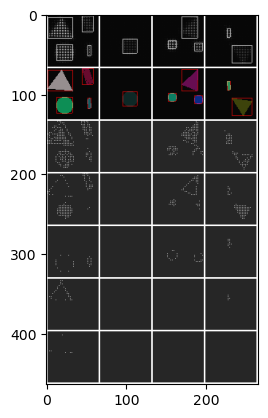

Showing output for test batch 51: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


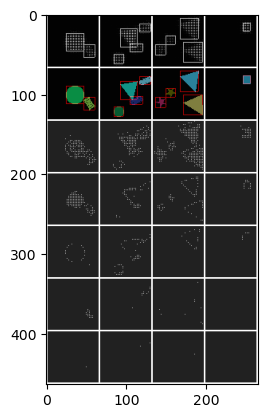

Showing output for test batch 101: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


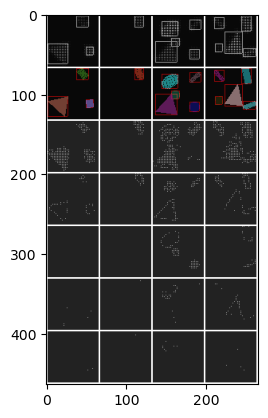

Showing output for test batch 151: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


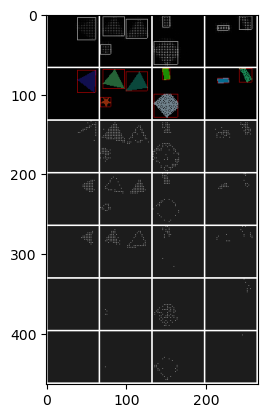

Showing output for test batch 201: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


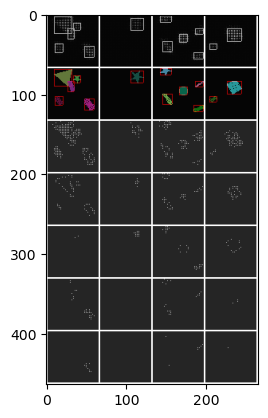

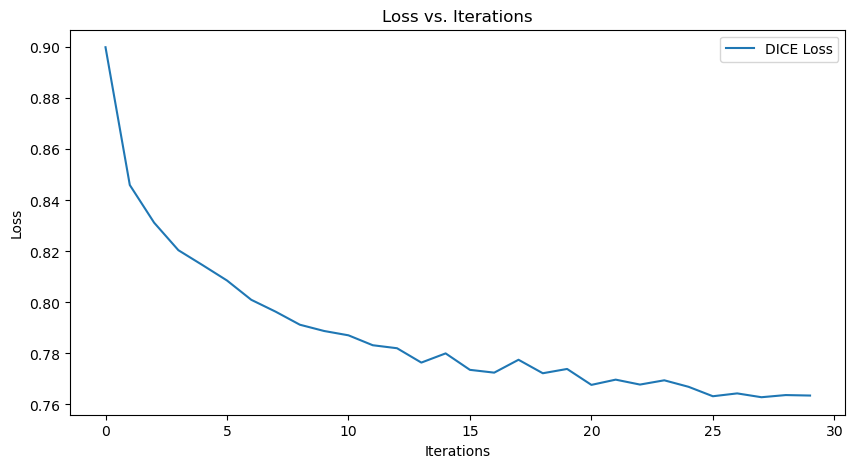

In [4]:

dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/PurdueShapes5MultiObject/",
                    dataroot = "./../data/datasets_for_DLStudio/data/",
                    image_size = [64,64],
                    path_saved_model = "./saved_model_DICE",
                    momentum = 0.9,
                    learning_rate = 1e-4,
                    epochs = 6,
                    batch_size = 4,
                    classes = ('rectangle','triangle','disk','oval','star'),
                    use_gpu = True,
                )

segmenter = DLStudio.SemanticSegmentation( 
                    dl_studio = dls, 
                    max_num_objects = 5,
                )

dataserver_train = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                            train_or_test = 'train',
                            dl_studio = dls,
                            segmenter = segmenter,
                            dataset_file = "PurdueShapes5MultiObject-10000-train.gz", 
                        )
dataserver_test = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                            train_or_test = 'test',
                            dl_studio = dls,
                            segmenter = segmenter,
                            dataset_file = "PurdueShapes5MultiObject-1000-test.gz"
                        )
segmenter.dataserver_train = dataserver_train
segmenter.dataserver_test = dataserver_test

segmenter.load_PurdueShapes5MultiObject_dataset(dataserver_train, dataserver_test)

model = segmenter.mUNet(skip_connections=True, depth=16)
#model = segmenter.mUNet(skip_connections=False, depth=4)

number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The number of learnable parameters in the model: %d\n" % number_of_learnable_params)

DICELoss = segmenter.DICE_run_code_for_training_for_semantic_segmentation(model)

segmenter.run_code_for_testing_semantic_segmentation(model)

plt.figure(figsize=(10,5))
plt.plot(DICELoss, label='DICE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.show()

segmenter.run_code_for_compute_iou(model)


## 2.3 MSE + Dice loss curve


Loading training data from torch saved file


C:\Users\alanc\AppData\Local\Temp\ipykernel_15728\1488550827.py:344: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.dataset = torch.load("torch_saved_PurdueShapes5MultiO

The number of learnable parameters in the model: 7688005


[epoch=1/6, iter= 500  elapsed_time=217 secs]   MSE loss: 488.640
[epoch=1/6, iter=1000  elapsed_time=438 secs]   MSE loss: 451.335
[epoch=1/6, iter=1500  elapsed_time=660 secs]   MSE loss: 423.454
[epoch=1/6, iter=2000  elapsed_time=881 secs]   MSE loss: 421.811
[epoch=1/6, iter=2500  elapsed_time=1103 secs]   MSE loss: 424.012

[epoch=2/6, iter= 500  elapsed_time=1321 secs]   MSE loss: 413.969
[epoch=2/6, iter=1000  elapsed_time=1540 secs]   MSE loss: 407.754
[epoch=2/6, iter=1500  elapsed_time=1759 secs]   MSE loss: 404.089
[epoch=2/6, iter=2000  elapsed_time=1979 secs]   MSE loss: 397.063
[epoch=2/6, iter=2500  elapsed_time=2201 secs]   MSE loss: 405.176

[epoch=3/6, iter= 500  elapsed_time=2422 secs]   MSE loss: 392.881
[epoch=3/6, iter=1000  elapsed_time=2643 secs]   MSE loss: 396.883
[epoch=3/6, iter=1500  elapsed_time=2869 secs]   MSE loss: 399.291
[epoch=3/6, iter=2000  elapsed_time=3089 secs]   MSE loss: 405.597
[epoc

C:\Users\alanc\AppData\Local\Temp\ipykernel_15728\1488550827.py:827: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(self.dl_studio.path_saved_m

Showing output for test batch 1: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


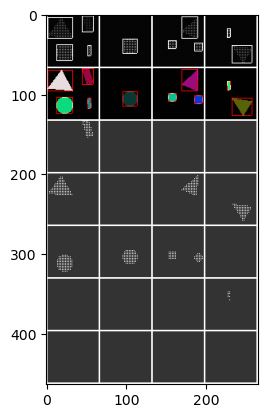

Showing output for test batch 51: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


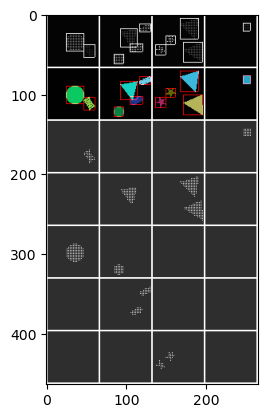

Showing output for test batch 101: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


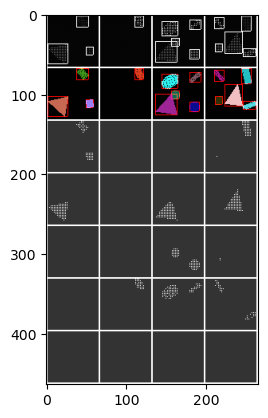

Showing output for test batch 151: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


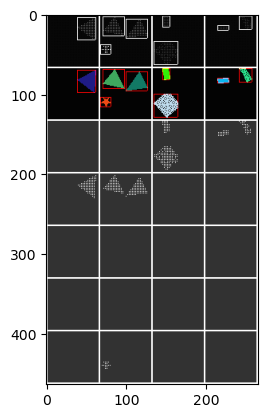

Showing output for test batch 201: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


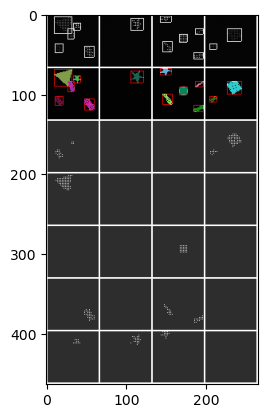

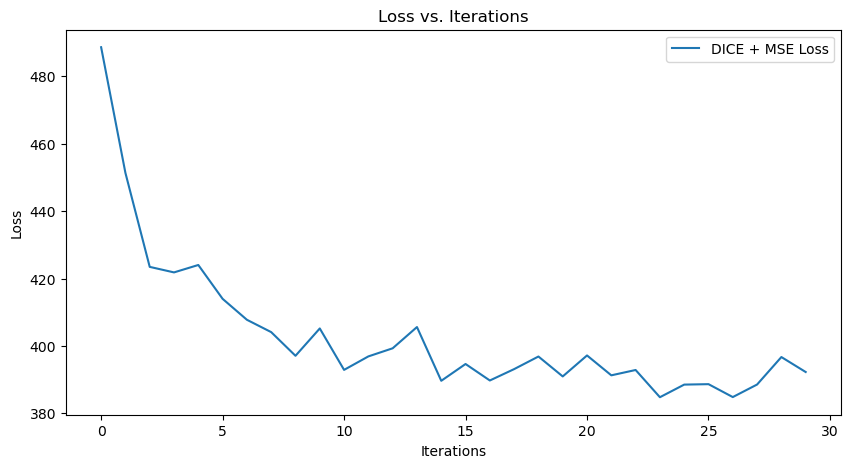

In [5]:
dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/PurdueShapes5MultiObject/",
                    dataroot = "./../data/datasets_for_DLStudio/data/",
                    image_size = [64,64],
                    path_saved_model = "./saved_model_DICE_MSE_50",
                    momentum = 0.9,
                    learning_rate = 1e-4,
                    epochs = 6,
                    batch_size = 4,
                    classes = ('rectangle','triangle','disk','oval','star'),
                    use_gpu = True,
                )

segmenter = DLStudio.SemanticSegmentation( 
                    dl_studio = dls, 
                    max_num_objects = 5,
                )

dataserver_train = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                            train_or_test = 'train',
                            dl_studio = dls,
                            segmenter = segmenter,
                            dataset_file = "PurdueShapes5MultiObject-10000-train.gz", 
                        )
dataserver_test = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                            train_or_test = 'test',
                            dl_studio = dls,
                            segmenter = segmenter,
                            dataset_file = "PurdueShapes5MultiObject-1000-test.gz"
                        )
segmenter.dataserver_train = dataserver_train
segmenter.dataserver_test = dataserver_test

segmenter.load_PurdueShapes5MultiObject_dataset(dataserver_train, dataserver_test)

model = segmenter.mUNet(skip_connections=True, depth=16)
#model = segmenter.mUNet(skip_connections=False, depth=4)

number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The number of learnable parameters in the model: %d\n" % number_of_learnable_params)

# DiceScale is a hyperparameter to scale the dice loss, adjust as needed
DICEMSELoss = segmenter.DICE_MSE_run_code_for_training_for_semantic_segmentation(model, DiceScale=50)

segmenter.run_code_for_testing_semantic_segmentation(model)

plt.figure(figsize=(10,5))
plt.plot(DICEMSELoss, label='DICE + MSE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.show()

segmenter.run_code_for_compute_iou(model)


# 3 Training worst curves

## 3.1 MSE loss curve

## 3.2 Dice loss curve

## 3.3 MSE + Dice loss curve

# 4 Observation on coefficient effect of MSE+Dice loss

## 4.1 Best set of scale values


Loading training data from torch saved file


C:\Users\alanc\AppData\Local\Temp\ipykernel_15728\1488550827.py:344: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.dataset = torch.load("torch_saved_PurdueShapes5MultiO

The number of learnable parameters in the model: 7688005


[epoch=1/6, iter= 500  elapsed_time=203 secs]   MSE loss: 577.330
[epoch=1/6, iter=1000  elapsed_time=412 secs]   MSE loss: 536.287
[epoch=1/6, iter=1500  elapsed_time=622 secs]   MSE loss: 495.981
[epoch=1/6, iter=2000  elapsed_time=840 secs]   MSE loss: 482.932
[epoch=1/6, iter=2500  elapsed_time=1050 secs]   MSE loss: 476.462

[epoch=2/6, iter= 500  elapsed_time=1257 secs]   MSE loss: 470.983
[epoch=2/6, iter=1000  elapsed_time=1483 secs]   MSE loss: 469.548
[epoch=2/6, iter=1500  elapsed_time=1694 secs]   MSE loss: 468.725
[epoch=2/6, iter=2000  elapsed_time=1903 secs]   MSE loss: 468.827
[epoch=2/6, iter=2500  elapsed_time=2113 secs]   MSE loss: 456.448

[epoch=3/6, iter= 500  elapsed_time=2321 secs]   MSE loss: 455.143
[epoch=3/6, iter=1000  elapsed_time=2532 secs]   MSE loss: 454.271
[epoch=3/6, iter=1500  elapsed_time=2744 secs]   MSE loss: 460.091
[epoch=3/6, iter=2000  elapsed_time=2955 secs]   MSE loss: 452.701
[epoc

C:\Users\alanc\AppData\Local\Temp\ipykernel_15728\1488550827.py:827: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(self.dl_studio.path_saved_m

Showing output for test batch 1: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


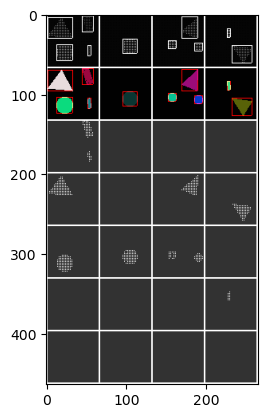

Showing output for test batch 51: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


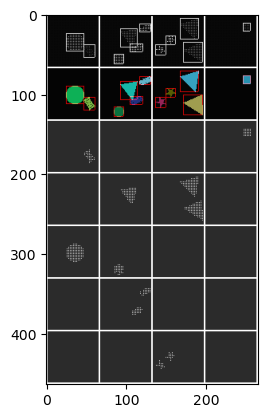

Showing output for test batch 101: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


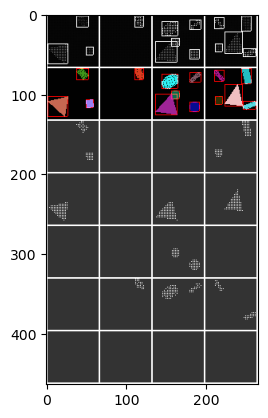

Showing output for test batch 151: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


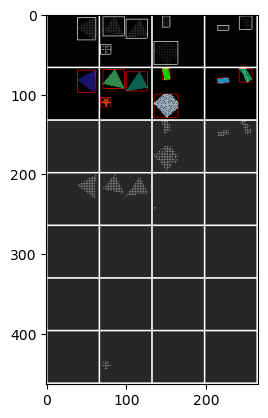

Showing output for test batch 201: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].


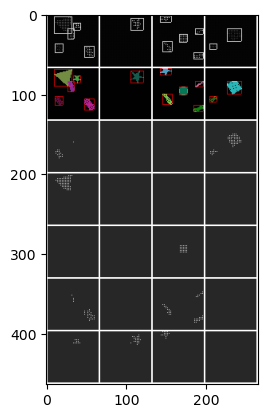

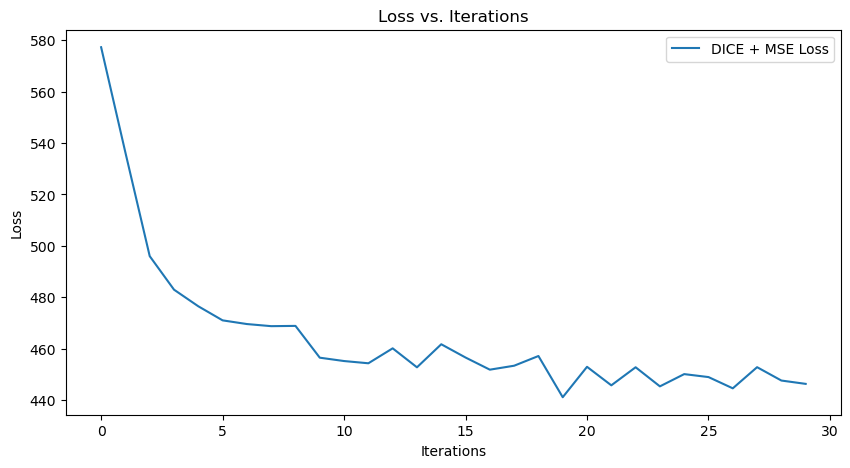

In [6]:
dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/PurdueShapes5MultiObject/",
                    dataroot = "./../data/datasets_for_DLStudio/data/",
                    image_size = [64,64],
                    path_saved_model = "./saved_model_DICE_MSE_150",
                    momentum = 0.9,
                    learning_rate = 1e-4,
                    epochs = 6,
                    batch_size = 4,
                    classes = ('rectangle','triangle','disk','oval','star'),
                    use_gpu = True,
                )

segmenter = DLStudio.SemanticSegmentation( 
                    dl_studio = dls, 
                    max_num_objects = 5,
                )

dataserver_train = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                            train_or_test = 'train',
                            dl_studio = dls,
                            segmenter = segmenter,
                            dataset_file = "PurdueShapes5MultiObject-10000-train.gz", 
                        )
dataserver_test = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                            train_or_test = 'test',
                            dl_studio = dls,
                            segmenter = segmenter,
                            dataset_file = "PurdueShapes5MultiObject-1000-test.gz"
                        )
segmenter.dataserver_train = dataserver_train
segmenter.dataserver_test = dataserver_test

segmenter.load_PurdueShapes5MultiObject_dataset(dataserver_train, dataserver_test)

model = segmenter.mUNet(skip_connections=True, depth=16)
#model = segmenter.mUNet(skip_connections=False, depth=4)

number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The number of learnable parameters in the model: %d\n" % number_of_learnable_params)

# DiceScale is a hyperparameter to scale the dice loss, adjust as needed
DICEMSELoss = segmenter.DICE_MSE_run_code_for_training_for_semantic_segmentation(model, DiceScale=150)

segmenter.run_code_for_testing_semantic_segmentation(model)

plt.figure(figsize=(10,5))
plt.plot(DICEMSELoss, label='DICE + MSE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.show()

segmenter.run_code_for_compute_iou(model)


## 4.2 Worst set of scale values

# 5 Evaluation and observation

In [1]:
from PIL import Image
import os
import json
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

# Loads an image, resizes it to 256x256, scales its BBox and segmentation, and saves the resized image.
# Returns the updated annotations.
def save_image(img_info, anns, img_dir, output_dir):
    img_path = os.path.normpath(os.path.join(img_dir, img_info['file_name']))
    os.makedirs(output_dir, exist_ok=True)

    if not os.path.exists(img_path):
        print(f"Skipping {img_path} - File not found.")
        return  

    # Load the image and compute scaling factors
    img = Image.open(img_path)
    width, height = img.size
    scale_w = 256 / width
    scale_h = 256 / height

    # Resize the image to 256x256 and update its info
    img = img.resize((256, 256))
    img_info['width'] = 256
    img_info['height'] = 256

    save_path = os.path.join(output_dir, img_info['file_name'])
    img.save(save_path)

    new_anns = []
    for ann in anns:
        # --- Update bounding box ---
        x, y, w, h = ann['bbox']
        x *= scale_w
        y *= scale_h
        w *= scale_w
        h *= scale_h
        ann['bbox'] = [x, y, w, h]
        ann['area'] = w * h

        # --- Update segmentation ---
        if isinstance(ann['segmentation'], list):
            # Polygon segmentation: scale each coordinate appropriately.
            new_segmentation = []
            for seg in ann['segmentation']:
                new_seg = []
                for i, coord in enumerate(seg):
                    if i % 2 == 0:  # x coordinate
                        new_seg.append(coord * scale_w)
                    else:           # y coordinate
                        new_seg.append(coord * scale_h)
                new_segmentation.append(new_seg)
            ann['segmentation'] = new_segmentation
        elif isinstance(ann['segmentation'], dict):
            # RLE segmentation: decode, resize mask, then re-encode.
            mask = maskUtils.decode(ann['segmentation'])
            mask_img = Image.fromarray(mask.astype('uint8') * 255)
            mask_img = mask_img.resize((256, 256), Image.NEAREST)
            new_mask = (np.array(mask_img) > 127).astype(np.uint8)
            new_rle = maskUtils.encode(np.asfortranarray(new_mask))
            # Convert counts from bytes to string if needed.
            if isinstance(new_rle['counts'], bytes):
                new_rle['counts'] = new_rle['counts'].decode('utf-8')
            ann['segmentation'] = new_rle

        new_anns.append(ann)

    return new_anns


def update_annotation_file(new_images, updated_anns, original_ann_file):
    # Load the original annotation file to retrieve the categories information
    with open(original_ann_file, 'r') as f:
        original_data = json.load(f)
    
    # Update the images and annotations fields
    original_data['images'] = new_images
    original_data['annotations'] = updated_anns
    
    # Write the updated data back to the original file
    with open(original_ann_file, 'w') as f:
        json.dump(original_data, f)


def extract_images(cat_names, img_dir, output_dir, ifVal):
    cat_ids = coco.getCatIds(catNms=cat_names)
    img_ids = coco.getImgIds(catIds=cat_ids)
    min_area = 40000  # 200x200

    valid_images = []
    target_category = ["pizza", "cat", "bus"]
    updated_anns_total = []

    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        if ifVal and "COCO_train2014_" in img_info["file_name"]:
            continue  # Skip training images for validation

        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
        anns = coco.loadAnns(ann_ids)

        valid_anns = []
        for ann in anns:
            obj_category = coco.loadCats(ann['category_id'])[0]['name']
            if obj_category in target_category and ann['area'] > min_area:
                valid_anns.append(ann)
        
        if valid_anns:
            new_anns = save_image(img_info, valid_anns, img_dir, output_dir)
            if new_anns:
                valid_images.append(img_info)
                updated_anns_total.extend(new_anns)

    return valid_images, updated_anns_total


# Set COCO dataset paths (update paths as needed)
ann_file_train = "./../data/annotations(HW8)/instances_train2014.json"
image_dir_train = "./../data/train2014"
output_dir_train = "./../data/Multi-instance_images_from_COCO(HW8)/train"
os.makedirs(output_dir_train, exist_ok=True)

ann_file_val = "./../data/annotations(HW8)/instances_val2014.json"
image_dir_val = "./../data/val2014"
output_dir_val = "./../data/Multi-instance_images_from_COCO(HW8)/val"
os.makedirs(output_dir_val, exist_ok=True)

all_new_images = []
all_updated_anns = []

# Process training data
coco = COCO(ann_file_train)

valid_images, updated_anns_total = extract_images(["pizza"], img_dir=image_dir_train, output_dir=output_dir_train, ifVal=False)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total = extract_images(["cat"], img_dir=image_dir_train, output_dir=output_dir_train, ifVal=False)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total = extract_images(["bus"], img_dir=image_dir_train, output_dir=output_dir_train, ifVal=False)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

update_annotation_file(all_new_images, all_updated_anns, ann_file_train)

# Process validation data
all_new_images = []
all_updated_anns = []

print(f"Loading COCO annotation file: {ann_file_val}")
coco = COCO(ann_file_val)

valid_images, updated_anns_total = extract_images(["pizza"], img_dir=image_dir_val, output_dir=output_dir_val, ifVal=True)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total = extract_images(["cat"], img_dir=image_dir_val, output_dir=output_dir_val, ifVal=True)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total = extract_images(["bus"], img_dir=image_dir_val, output_dir=output_dir_val, ifVal=True)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

update_annotation_file(all_new_images, all_updated_anns, ann_file_val)


loading annotations into memory...
Done (t=10.57s)
creating index...
index created!
Loading COCO annotation file: ./../data/annotations(HW8)/instances_val2014.json
loading annotations into memory...
Done (t=4.92s)
creating index...
index created!


In [13]:
# data loader for the COCO dataset 

import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
from pycocotools import mask as maskUtils 


class MyDataset(Dataset):
    def __init__(self, ann_file, image_dir, img_transform, mask_transform):
        # Load the annotation JSON file
        with open(ann_file, 'r') as f:
            self.annotation = json.load(f)
        
        self.image_dir = image_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
        # Build an index mapping image id to its annotations
        self.img_id_to_anns = {}
        for ann in self.annotation['annotations']:
            img_id = ann['image_id']
            if img_id not in self.img_id_to_anns:
                self.img_id_to_anns[img_id] = []
            self.img_id_to_anns[img_id].append(ann)
        
        # List of image info dictionaries
        self.images = self.annotation['images']

        # Mapping from original category IDs to our indices.
        # Here we label: pizza (59) -> 1, cat (17) -> 2, bus (6) -> 3
        # Background is 0.
        self.catid_to_idx = {59: 1, 17: 2, 6: 3}

    
    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, idx):
        # Get image info and path
        img_info = self.images[idx]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        
        # Open image and get original size
        image = Image.open(img_path).convert('RGB')
        width, height = image.size
        
        # Create an empty mask (background=0)
        mask = np.zeros((height, width), dtype=np.uint8)
        
        # Check if there are any annotations for this image
        if img_info['id'] in self.img_id_to_anns:
            for ann in self.img_id_to_anns[img_info['id']]:
                cat_id = ann['category_id']
                if cat_id in self.catid_to_idx:
                    label = self.catid_to_idx[cat_id]
                    segm = ann['segmentation']
                    # If segmentation is provided as a polygon (list of lists)
                    if isinstance(segm, list):
                        # Create a blank mask for the polygon and draw the segmentation
                        poly_mask = Image.new('L', (width, height), 0)
                        for polygon in segm:
                            # polygon is a list of x,y coordinates
                            ImageDraw.Draw(poly_mask).polygon(polygon, outline=1, fill=1)
                        poly_mask = np.array(poly_mask, dtype=bool)
                    else:
                        # Otherwise, assume RLE and decode it
                        poly_mask = maskUtils.decode(segm).astype(bool)
                    
                    # Assign label to mask where the object is present
                    mask[poly_mask] = label
        
        # Apply the image transform
        image_tensor = self.img_transform(image)
        
        # Convert the mask to a PIL image and apply mask transforms.
        # We use nearest neighbor interpolation for masks.
        mask_pil = Image.fromarray(mask)
        mask_resized = self.mask_transform(mask_pil)
        
        # Convert single-channel mask to one-hot format with 5 channels (background + 4 classes)
        mask_tensor = mask_resized.long()
        num_classes = 4  # Background (0) + 3 classes
        one_hot_mask = torch.zeros((num_classes, mask_tensor.shape[1], mask_tensor.shape[2]))
        for i in range(num_classes):
            one_hot_mask[i] = (mask_tensor == i).float()

        # Dummy bounding box tensor (not used in this homework)
        bbox_tensor = torch.zeros(5, 4)

        sample = {'image': image_tensor, 'mask_tensor': one_hot_mask, 'bbox_tensor': bbox_tensor}
        return sample



img_transform = transforms.Compose([
    transforms.Resize((64, 64)), 

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])



# For masks, we only resize using nearest neighbor and convert to tensor.
mask_transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=Image.NEAREST),  
    transforms.ToTensor() 
])


ann_file_train = "./../data/annotations(HW8)/instances_train2014.json"
image_dir_train = "./../data/Multi-instance_images_from_COCO(HW8)/train"
ann_file_val = "./../data/annotations(HW8)/instances_val2014.json"
image_dir_val = "./../data/Multi-instance_images_from_COCO(HW8)/val"

train_dataset = MyDataset(ann_file=ann_file_train, image_dir=image_dir_train, img_transform=img_transform, mask_transform=mask_transform)
val_dataset = MyDataset(ann_file=ann_file_val, image_dir=image_dir_val,img_transform=img_transform, mask_transform=mask_transform)

# Create a DataLoader to iterate through the dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Test a sample
sample = train_dataset[0]
image_tensor = sample['image']
mask_tensor = sample['mask_tensor']
print("Image shape:", image_tensor.shape)
print("Mask shape:", mask_tensor.shape)



Image shape: torch.Size([3, 64, 64])
Mask shape: torch.Size([4, 64, 64])


## 5.1 3 images MSE

In [16]:
# this code is mostly borrowed from DLStudio

import torch.optim as optim
import torch
import torch.nn as nn
import copy
import time
import gzip
import pickle
import numpy as np
import os
import sys
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F


class DLStudio(object):
    def __init__(self, *args, **kwargs ):
        if args:
            raise ValueError(  
                   '''DLStudio constructor can only be called with keyword arguments for 
                      the following keywords: epochs, learning_rate, batch_size, momentum,
                      convo_layers_config, image_size, dataroot, path_saved_model, classes, 
                      image_size, convo_layers_config, fc_layers_config, debug_train, use_gpu, and 
                      debug_test''')
        learning_rate = epochs = batch_size = convo_layers_config = momentum = None
        image_size = fc_layers_config = dataroot =  path_saved_model = classes = use_gpu = None
        debug_train  = debug_test = None
        if 'dataroot' in kwargs                      :   dataroot = kwargs.pop('dataroot')
        if 'learning_rate' in kwargs                 :   learning_rate = kwargs.pop('learning_rate')
        if 'momentum' in kwargs                      :   momentum = kwargs.pop('momentum')
        if 'epochs' in kwargs                        :   epochs = kwargs.pop('epochs')
        if 'batch_size' in kwargs                    :   batch_size = kwargs.pop('batch_size')
        if 'convo_layers_config' in kwargs           :   convo_layers_config = kwargs.pop('convo_layers_config')
        if 'image_size' in kwargs                    :   image_size = kwargs.pop('image_size')
        if 'fc_layers_config' in kwargs              :   fc_layers_config = kwargs.pop('fc_layers_config')
        if 'path_saved_model' in kwargs              :   path_saved_model = kwargs.pop('path_saved_model')
        if 'classes' in kwargs                       :   classes = kwargs.pop('classes') 
        if 'use_gpu' in kwargs                       :   use_gpu = kwargs.pop('use_gpu') 
        if 'debug_train' in kwargs                   :   debug_train = kwargs.pop('debug_train') 
        if 'debug_test' in kwargs                    :   debug_test = kwargs.pop('debug_test') 
        if len(kwargs) != 0: raise ValueError('''You have provided unrecognizable keyword args''')
        if dataroot:
            self.dataroot = dataroot
        if convo_layers_config:
            self.convo_layers_config = convo_layers_config
        if image_size:
            self.image_size = image_size
        if fc_layers_config:
            self.fc_layers_config = fc_layers_config
            if fc_layers_config[0] != -1:
                raise Exception("""\n\n\nYour 'fc_layers_config' construction option is not correct. """
                                """The first element of the list of nodes in the fc layer must be -1 """
                                """because the input to fc will be set automatically to the size of """
                                """the final activation volume of the convolutional part of the network""")
        if  path_saved_model:
            self.path_saved_model = path_saved_model
        if classes:
            self.class_labels = classes
        if learning_rate:
            self.learning_rate = learning_rate
        else:
            self.learning_rate = 1e-6
        if momentum:
            self.momentum = momentum
        if epochs:
            self.epochs = epochs
        if batch_size:
            self.batch_size = batch_size
        if use_gpu is not None:
            self.use_gpu = use_gpu
            if use_gpu is True:
                if torch.cuda.is_available():
                    self.device = torch.device("cuda:0")
                else: 
                    self.device = torch.device("cpu")
        else:
            self.device = torch.device("cpu")
        if debug_train:                             
            self.debug_train = debug_train
        else:
            self.debug_train = 0
        if debug_test:                             
            self.debug_test = debug_test
        else:
            self.debug_test = 0
        self.debug_config = 0


    def imshow(self, img):
        '''
        called by display_tensor_as_image() for displaying the image
        '''
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    
    def dice_loss(preds: torch.Tensor, ground_truth: torch.Tensor):
        # prevents division by zero
        epsilon=1e-6

        # Step 1: Compute Dice Coefficient.
        # For the numerator, multiply the prediction with the ground truth and compute 
        # the sum of elements(in H and W dimensions).
        # shape of preds and ground_truth is (N, C, H, W), so dim 1, 2, 3 are C, H, W
        # we want to sum over C, H, W dimensions so that we aggregate the loss across 
        # all object classes (global dice loss. MSE do the samething)
        numerator = torch.sum(preds * ground_truth, dim=(1, 2, 3)) 

        # For the denominator,  multiply prediction with
        # itself and sum the elements(in H and W dimensions) and multiply ground
        # truth by itself and sum the elements(in H and W dimensions).
        denominator = torch.sum(preds ** 2, dim=(1, 2, 3)) + torch.sum(ground_truth ** 2, dim=(1, 2, 3))

        # Step 2: dice_coeffecient = 2 * numerator / (denominator + epsilon)
        dice_coefficient = 2 * numerator / (denominator + epsilon)

        # Step 3: Compute dice_loss = 1 - dice_coefficient
        dice_loss = 1 - dice_coefficient.mean()

        return dice_loss

    def display_tensor_as_image(self, tensor, title=""):

        tensor_range = (torch.min(tensor).item(), torch.max(tensor).item())
        if tensor_range == (-1.0,1.0):
            ##  The tensors must be between 0.0 and 1.0 for the display:
            print("\n\n\nimage un-normalization called")
            tensor = tensor/2.0 + 0.5     # unnormalize
        plt.figure(title)
        ###  The call to plt.imshow() shown below needs a numpy array. We must also
        ###  transpose the array so that the number of channels (the same thing as the
        ###  number of color planes) is in the last element.  For a tensor, it would be in
        ###  the first element.
        if tensor.shape[0] == 3 and len(tensor.shape) == 3:
#            plt.imshow( tensor.numpy().transpose(1,2,0) )
            plt.imshow( tensor.numpy().transpose(1,2,0) )
        ###  If the grayscale image was produced by calling torchvision.transform's
        ###  ".ToPILImage()", and the result converted to a tensor, the tensor shape will
        ###  again have three elements in it, however the first element that stands for
        ###  the number of channels will now be 1
        elif tensor.shape[0] == 1 and len(tensor.shape) == 3:
            tensor = tensor[0,:,:]
            plt.imshow( tensor.numpy(), cmap = 'gray' )
        ###  For any one color channel extracted from the tensor representation of a color
        ###  image, the shape of the tensor will be (W,H):
        elif len(tensor.shape) == 2:
            plt.imshow( tensor.numpy(), cmap = 'gray' )
        else:
            sys.exit("\n\n\nfrom 'display_tensor_as_image()': tensor for image is ill formed -- aborting")
        plt.show()




    class SemanticSegmentation(nn.Module):             
        def __init__(self, dl_studio, max_num_objects, dataserver_train=None, dataserver_test=None, dataset_file_train=None, dataset_file_test=None):
            super(DLStudio.SemanticSegmentation, self).__init__()
            self.dl_studio = dl_studio
            self.max_num_objects = max_num_objects
            self.dataserver_train = dataserver_train
            self.dataserver_test = dataserver_test


        class PurdueShapes5MultiObjectDataset(torch.utils.data.Dataset):
            def __init__(self, dl_studio, segmenter, train_or_test, dataset_file):
                super(DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset, self).__init__()
                max_num_objects = segmenter.max_num_objects
                if train_or_test == 'train' and dataset_file == "PurdueShapes5MultiObject-10000-train.gz":
                    if os.path.exists("torch_saved_PurdueShapes5MultiObject-10000_dataset.pt") and \
                              os.path.exists("torch_saved_PurdueShapes5MultiObject_label_map.pt"):
                        print("\nLoading training data from torch saved file")
                        self.dataset = torch.load("torch_saved_PurdueShapes5MultiObject-10000_dataset.pt")
                        self.label_map = torch.load("torch_saved_PurdueShapes5MultiObject_label_map.pt")
                        self.num_shapes = len(self.label_map)
                        self.image_size = dl_studio.image_size
                    else: 
                        print("""\n\n\nLooks like this is the first time you will be loading in\n"""
                              """the dataset for this script. First time loading could take\n"""
                              """a few minutes.  Any subsequent attempts will only take\n"""
                              """a few seconds.\n\n\n""")
                        root_dir = dl_studio.dataroot
                        f = gzip.open(root_dir + dataset_file, 'rb')
                        dataset = f.read()
                        self.dataset, self.label_map = pickle.loads(dataset, encoding='latin1')
                        torch.save(self.dataset, "torch_saved_PurdueShapes5MultiObject-10000_dataset.pt")
                        torch.save(self.label_map, "torch_saved_PurdueShapes5MultiObject_label_map.pt")
                        # reverse the key-value pairs in the label dictionary:
                        self.class_labels = dict(map(reversed, self.label_map.items()))
                        self.num_shapes = len(self.class_labels)
                        self.image_size = dl_studio.image_size
                else:
                    root_dir = dl_studio.dataroot
                    f = gzip.open(root_dir + dataset_file, 'rb')
                    dataset = f.read()
                    if sys.version_info[0] == 3:
                        self.dataset, self.label_map = pickle.loads(dataset, encoding='latin1')
                    else:
                        self.dataset, self.label_map = pickle.loads(dataset)
                    # reverse the key-value pairs in the label dictionary:
                    self.class_labels = dict(map(reversed, self.label_map.items()))
                    self.num_shapes = len(self.class_labels)
                    self.image_size = dl_studio.image_size

            def __len__(self):
                return len(self.dataset)

            def __getitem__(self, idx):
                image_size = self.image_size
                r = np.array( self.dataset[idx][0] )
                g = np.array( self.dataset[idx][1] )
                b = np.array( self.dataset[idx][2] )
                R,G,B = r.reshape(image_size[0],image_size[1]), g.reshape(image_size[0],image_size[1]), b.reshape(image_size[0],image_size[1])
                im_tensor = torch.zeros(3,image_size[0],image_size[1], dtype=torch.float)
                im_tensor[0,:,:] = torch.from_numpy(R)
                im_tensor[1,:,:] = torch.from_numpy(G)
                im_tensor[2,:,:] = torch.from_numpy(B)
                mask_array = np.array(self.dataset[idx][3])
                max_num_objects = len( mask_array[0] ) 
                mask_tensor = torch.from_numpy(mask_array)
                mask_val_to_bbox_map =  self.dataset[idx][4]
                max_bboxes_per_entry_in_map = max([ len(mask_val_to_bbox_map[key]) for key in mask_val_to_bbox_map ])
                ##  The first arg 5 is for the number of bboxes we are going to need. If all the
                ##  shapes are exactly the same, you are going to need five different bbox'es.
                ##  The second arg is the index reserved for each shape in a single bbox
                bbox_tensor = torch.zeros(max_num_objects,self.num_shapes,4, dtype=torch.float)
                for bbox_idx in range(max_bboxes_per_entry_in_map):
                    for key in mask_val_to_bbox_map:
                        if len(mask_val_to_bbox_map[key]) == 1:
                            if bbox_idx == 0:
                                bbox_tensor[bbox_idx,key,:] = torch.from_numpy(np.array(mask_val_to_bbox_map[key][bbox_idx]))
                        elif len(mask_val_to_bbox_map[key]) > 1 and bbox_idx < len(mask_val_to_bbox_map[key]):
                            bbox_tensor[bbox_idx,key,:] = torch.from_numpy(np.array(mask_val_to_bbox_map[key][bbox_idx]))
                sample = {'image'        : im_tensor, 
                          'mask_tensor'  : mask_tensor,
                          'bbox_tensor'  : bbox_tensor }
                return sample

        def load_PurdueShapes5MultiObject_dataset(self, dataserver_train, dataserver_test ):   
            self.train_dataloader = torch.utils.data.DataLoader(dataserver_train,
                        batch_size=self.dl_studio.batch_size,shuffle=True, num_workers=0)
            self.test_dataloader = torch.utils.data.DataLoader(dataserver_test,
                               batch_size=self.dl_studio.batch_size,shuffle=False, num_workers=0)


        class SkipBlockDN(nn.Module):

            def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
                super(DLStudio.SemanticSegmentation.SkipBlockDN, self).__init__()
                self.downsample = downsample
                self.skip_connections = skip_connections
                self.in_ch = in_ch
                self.out_ch = out_ch

                # UP is using ConvTranspose2d, DN is using Conv2d
                self.convo1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
                self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)

                self.bn1 = nn.BatchNorm2d(out_ch)
                self.bn2 = nn.BatchNorm2d(out_ch)
                if downsample:
                    # UP is using ConvTranspose2d, DN is using Conv2d
                    self.downsampler = nn.Conv2d(in_ch, out_ch, 1, stride=2)
            def forward(self, x):
                identity = x                                     
                out = self.convo1(x)                              
                out = self.bn1(out)                              
                out = nn.functional.relu(out)
                if self.in_ch == self.out_ch:
                    out = self.convo2(out)                              
                    out = self.bn2(out)                              
                    out = nn.functional.relu(out)
                if self.downsample:
                    out = self.downsampler(out)
                    identity = self.downsampler(identity)
                if self.skip_connections:
                    if self.in_ch == self.out_ch:
                        out = out + identity
                    else:
                        out = out + torch.cat((identity, identity), dim=1) 
                return out


        class SkipBlockUP(nn.Module):
            def __init__(self, in_ch, out_ch, upsample=False, skip_connections=True):
                super(DLStudio.SemanticSegmentation.SkipBlockUP, self).__init__()
                self.upsample = upsample
                self.skip_connections = skip_connections
                self.in_ch = in_ch
                self.out_ch = out_ch

                # DN is using Conv2d, UP is using ConvTranspose2d
                self.convoT1 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)
                self.convoT2 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)

                self.bn1 = nn.BatchNorm2d(out_ch)
                self.bn2 = nn.BatchNorm2d(out_ch)
                if upsample:
                    # DN is using Conv2d, UP is using ConvTranspose2d
                    self.upsampler = nn.ConvTranspose2d(in_ch, out_ch, 1, stride=2, dilation=2, output_padding=1, padding=0)
            def forward(self, x):
                identity = x                                     
                out = self.convoT1(x)                              
                out = self.bn1(out)                              
                out = nn.functional.relu(out)
                out  =  nn.ReLU(inplace=False)(out)            
                if self.in_ch == self.out_ch:
                    out = self.convoT2(out)                              
                    out = self.bn2(out)                              
                    out = nn.functional.relu(out)
                if self.upsample:
                    out = self.upsampler(out)
                    identity = self.upsampler(identity)
                if self.skip_connections:
                    if self.in_ch == self.out_ch:
                        out = out + identity                              
                    else:
                        out = out + identity[:,self.out_ch:,:,:]
                return out
            
        class ASPP(nn.Module):
            def __init__(self, in_ch, out_ch):
                super(DLStudio.SemanticSegmentation.ASPP, self).__init__()
                self.conv1 = nn.Conv2d(in_ch, out_ch, 1)

                # padding needs to be eqaul to dilation when kernel size is 3. So that the output size is 
                # same as input size. 
                # (formula: out_size = (in_size + 2*padding - dilation*(kernel_size-1) - 1)/stride + 1)
                self.conv2 = nn.Conv2d(in_ch, out_ch, 3, padding=6, dilation=6) 
                self.conv3 = nn.Conv2d(in_ch, out_ch, 3, padding=12, dilation=12)
                self.conv4 = nn.Conv2d(in_ch, out_ch, 3, padding=18, dilation=18)
                self.conv5 = nn.Conv2d(in_ch, out_ch, 3, padding=24, dilation=24)

                # final conv for concatenation
                self.conv6 = nn.Conv2d(out_ch*5, out_ch, 1)
            def forward(self, x):
                out1 = self.conv1(x)
                out2 = self.conv2(x)
                out3 = self.conv3(x)
                out4 = self.conv4(x)
                out5 = self.conv5(x)
                out = torch.cat([out1, out2, out3, out4, out5], dim=1)
                out = self.conv6(out)
                return out
        

        class mUNet(nn.Module):
            def __init__(self, skip_connections=True, depth=16):
                super(DLStudio.SemanticSegmentation.mUNet, self).__init__()
                self.depth = depth // 2
                self.conv_in = nn.Conv2d(3, 64, 3, padding=1)
                ##  For the DN(down) arm of the U:
                self.bn1DN  = nn.BatchNorm2d(64)
                self.bn2DN  = nn.BatchNorm2d(128)
                self.skip64DN_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip64DN_arr.append(DLStudio.SemanticSegmentation.SkipBlockDN(64, 64, skip_connections=skip_connections))
                self.skip64dsDN = DLStudio.SemanticSegmentation.SkipBlockDN(64, 64,   downsample=True, skip_connections=skip_connections)
                self.skip64to128DN = DLStudio.SemanticSegmentation.SkipBlockDN(64, 128, skip_connections=skip_connections )
                self.skip128DN_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip128DN_arr.append(DLStudio.SemanticSegmentation.SkipBlockDN(128, 128, skip_connections=skip_connections))
                self.skip128dsDN = DLStudio.SemanticSegmentation.SkipBlockDN(128,128, downsample=True, skip_connections=skip_connections)
                


                # add ASPP block before going up
                self.aspp = DLStudio.SemanticSegmentation.ASPP(128, 128)



                ##  For the UP arm of the U:
                self.bn1UP  = nn.BatchNorm2d(128)
                self.bn2UP  = nn.BatchNorm2d(64)
                self.skip64UP_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip64UP_arr.append(DLStudio.SemanticSegmentation.SkipBlockUP(64, 64, skip_connections=skip_connections))
                self.skip64usUP = DLStudio.SemanticSegmentation.SkipBlockUP(64, 64, upsample=True, skip_connections=skip_connections)
                self.skip128to64UP = DLStudio.SemanticSegmentation.SkipBlockUP(128, 64, skip_connections=skip_connections )
                self.skip128UP_arr = nn.ModuleList()
                for i in range(self.depth):
                    self.skip128UP_arr.append(DLStudio.SemanticSegmentation.SkipBlockUP(128, 128, skip_connections=skip_connections))
                self.skip128usUP = DLStudio.SemanticSegmentation.SkipBlockUP(128,128, upsample=True, skip_connections=skip_connections)
                


                #  change this into 4 classes
                # self.conv_out = nn.ConvTranspose2d(64, 5, 3, stride=2,dilation=2,output_padding=1,padding=2)
                self.conv_out = nn.ConvTranspose2d(64, 4, 3, stride=2,dilation=2,output_padding=1,padding=2)




            def forward(self, x):
                ##  Going down to the bottom of the U:
                x = nn.MaxPool2d(2,2)(nn.functional.relu(self.conv_in(x)))          
                for i,skip64 in enumerate(self.skip64DN_arr[:self.depth//4]):
                    x = skip64(x)                
        
                num_channels_to_save1 = x.shape[1] // 2 # x.shape[1] is the number of output channels
                save_for_upside_1 = x[:,:num_channels_to_save1,:,:].clone()
                x = self.skip64dsDN(x)
                for i,skip64 in enumerate(self.skip64DN_arr[self.depth//4:]):
                    x = skip64(x)                
                x = self.bn1DN(x)
                num_channels_to_save2 = x.shape[1] // 2
                save_for_upside_2 = x[:,:num_channels_to_save2,:,:].clone()
                x = self.skip64to128DN(x)
                for i,skip128 in enumerate(self.skip128DN_arr[:self.depth//4]):
                    x = skip128(x)                
        
                x = self.bn2DN(x)
                num_channels_to_save3 = x.shape[1] // 2
                save_for_upside_3 = x[:,:num_channels_to_save3,:,:].clone()
                for i,skip128 in enumerate(self.skip128DN_arr[self.depth//4:]):
                    x = skip128(x)                
                x = self.skip128dsDN(x)



                # add ASPP block beforing going up
                x = self.aspp(x)



                ## Coming up from the bottom of U on the other side:
                x = self.skip128usUP(x)          
                for i,skip128 in enumerate(self.skip128UP_arr[:self.depth//4]):
                    x = skip128(x)                
                x[:,:num_channels_to_save3,:,:] =  save_for_upside_3
                x = self.bn1UP(x)
                for i,skip128 in enumerate(self.skip128UP_arr[:self.depth//4]):
                    x = skip128(x)                
                x = self.skip128to64UP(x)
                for i,skip64 in enumerate(self.skip64UP_arr[self.depth//4:]):
                    x = skip64(x)                
                x[:,:num_channels_to_save2,:,:] =  save_for_upside_2
                x = self.bn2UP(x)
                x = self.skip64usUP(x)
                for i,skip64 in enumerate(self.skip64UP_arr[:self.depth//4]):
                    x = skip64(x)                
                x[:,:num_channels_to_save1,:,:] =  save_for_upside_1
                x = self.conv_out(x)
                return x
        

        class SegmentationLoss(nn.Module):
            def __init__(self, batch_size):
                super(DLStudio.SemanticSegmentation.SegmentationLoss, self).__init__()
                self.batch_size = batch_size
            def forward(self, output, mask_tensor):
                composite_loss = torch.zeros(1,self.batch_size)
                mask_based_loss = torch.zeros(1,5)
                for idx in range(self.batch_size):
                    outputh = output[idx,0,:,:]
                    for mask_layer_idx in range(mask_tensor.shape[0]):
                        mask = mask_tensor[idx,mask_layer_idx,:,:]
                        element_wise = (outputh - mask)**2                   
                        mask_based_loss[0,mask_layer_idx] = torch.mean(element_wise)
                    composite_loss[0,idx] = torch.sum(mask_based_loss)
                return torch.sum(composite_loss) / self.batch_size


        def MSE_run_code_for_training_for_semantic_segmentation(self, net):        
            filename_for_out1 = "performance_numbers_" + str(self.dl_studio.epochs) + ".txt"
            FILE1 = open(filename_for_out1, 'w')
            net = copy.deepcopy(net)
            net = net.to(self.dl_studio.device)

            # using MSE loss
            criterion1 = nn.MSELoss()

            optimizer = optim.SGD(net.parameters(), 
                         lr=self.dl_studio.learning_rate, momentum=self.dl_studio.momentum)
            start_time = time.perf_counter()

            # record the loss values
            total_loss = []

            for epoch in range(self.dl_studio.epochs):  
                print("")
                running_loss_segmentation = 0.0
                for i, data in enumerate(self.train_dataloader):    
                    im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                    im_tensor   = im_tensor.to(self.dl_studio.device)
                    mask_tensor = mask_tensor.type(torch.FloatTensor)
                    mask_tensor = mask_tensor.to(self.dl_studio.device)                 
                    bbox_tensor = bbox_tensor.to(self.dl_studio.device)
                    optimizer.zero_grad()
                    output = net(im_tensor) 
                    segmentation_loss = criterion1(output, mask_tensor)  
                    segmentation_loss.backward()
                    optimizer.step()
                    running_loss_segmentation += segmentation_loss.item()    
                    if i%500==499:    
                        current_time = time.perf_counter()
                        elapsed_time = current_time - start_time
                        avg_loss_segmentation = running_loss_segmentation / float(500)
                        print("[epoch=%d/%d, iter=%4d  elapsed_time=%3d secs]   loss: %.3f" % (epoch+1, self.dl_studio.epochs, i+1, elapsed_time, avg_loss_segmentation))
                        total_loss.append(avg_loss_segmentation)
                        FILE1.write("%.3f\n" % avg_loss_segmentation)
                        FILE1.flush()
                        running_loss_segmentation = 0.0
            print("\nFinished Training\n")
            self.save_model(net)

            return total_loss


        def DICE_run_code_for_training_for_semantic_segmentation(self, net):        
            filename_for_out1 = "performance_numbers_" + str(self.dl_studio.epochs) + ".txt"
            FILE1 = open(filename_for_out1, 'w')
            net = copy.deepcopy(net)
            net = net.to(self.dl_studio.device)

            optimizer = optim.SGD(net.parameters(), 
                         lr=self.dl_studio.learning_rate, momentum=self.dl_studio.momentum)
            start_time = time.perf_counter()

            # record the loss values
            total_loss = []

            for epoch in range(self.dl_studio.epochs):  
                print("")
                running_loss_segmentation = 0.0
                for i, data in enumerate(self.train_dataloader):    
                    im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                    im_tensor   = im_tensor.to(self.dl_studio.device)
                    mask_tensor = mask_tensor.type(torch.FloatTensor)
                    mask_tensor = mask_tensor.to(self.dl_studio.device)                 
                    bbox_tensor = bbox_tensor.to(self.dl_studio.device)
                    optimizer.zero_grad()
                    output = net(im_tensor) 

                    # using DICE loss
                    segmentation_loss = DLStudio.dice_loss(output, mask_tensor)

                    segmentation_loss.backward()
                    optimizer.step()
                    running_loss_segmentation += segmentation_loss.item()    
                    if i%500==499:    
                        current_time = time.perf_counter()
                        elapsed_time = current_time - start_time
                        avg_loss_segmentation = running_loss_segmentation / float(500)
                        print("[epoch=%d/%d, iter=%4d  elapsed_time=%3d secs]   MSE loss: %.3f" % (epoch+1, self.dl_studio.epochs, i+1, elapsed_time, avg_loss_segmentation))
                        total_loss.append(avg_loss_segmentation)
                        FILE1.write("%.3f\n" % avg_loss_segmentation)
                        FILE1.flush()
                        running_loss_segmentation = 0.0
            print("\nFinished Training\n")
            self.save_model(net)
            return total_loss
        

        def DICE_MSE_run_code_for_training_for_semantic_segmentation(self, net, DiceScale):
            filename_for_out1 = "performance_numbers_" + str(self.dl_studio.epochs) + ".txt"
            FILE1 = open(filename_for_out1, 'w')
            net = copy.deepcopy(net)
            net = net.to(self.dl_studio.device)

            optimizer = optim.SGD(net.parameters(), 
                         lr=self.dl_studio.learning_rate, momentum=self.dl_studio.momentum)
            start_time = time.perf_counter()

            # record the loss values
            total_loss = []

            for epoch in range(self.dl_studio.epochs):  
                print("")
                running_loss_segmentation = 0.0
                for i, data in enumerate(self.train_dataloader):    
                    im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                    im_tensor   = im_tensor.to(self.dl_studio.device)
                    mask_tensor = mask_tensor.type(torch.FloatTensor)
                    mask_tensor = mask_tensor.to(self.dl_studio.device)                 
                    bbox_tensor = bbox_tensor.to(self.dl_studio.device)
                    optimizer.zero_grad()
                    output = net(im_tensor) 



                    # using DICE+MSE loss
                    dice_scale = DiceScale
                    segmentation_loss = dice_scale * DLStudio.dice_loss(output, mask_tensor)
                    segmentation_loss += nn.MSELoss()(output, mask_tensor)



                    segmentation_loss.backward()
                    optimizer.step()
                    running_loss_segmentation += segmentation_loss.item()    
                    if i%500==499:    
                        current_time = time.perf_counter()
                        elapsed_time = current_time - start_time
                        avg_loss_segmentation = running_loss_segmentation / float(500)
                        print("[epoch=%d/%d, iter=%4d  elapsed_time=%3d secs]   MSE loss: %.3f" % (epoch+1, self.dl_studio.epochs, i+1, elapsed_time, avg_loss_segmentation))
                        total_loss.append(avg_loss_segmentation)
                        FILE1.write("%.3f\n" % avg_loss_segmentation)
                        FILE1.flush()
                        running_loss_segmentation = 0.0
            print("\nFinished Training\n")
            self.save_model(net)
            return total_loss


        def save_model(self, model):
            '''
            Save the trained model to a disk file
            '''
            torch.save(model.state_dict(), self.dl_studio.path_saved_model)


        def run_code_for_testing_semantic_segmentation(self, net):
            net.load_state_dict(torch.load(self.dl_studio.path_saved_model))
            batch_size = self.dl_studio.batch_size
            image_size = self.dl_studio.image_size
            max_num_objects = self.max_num_objects

            count = 0


            with torch.no_grad():
                for i, data in enumerate(self.test_dataloader):
                    im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                    if i % 50 == 0:
                        count += 1
                        if count > 3:
                            break
                        print("Showing output for test batch %d: " % (i+1))
                        outputs = net(im_tensor)                        
                        ## In the statement below: 1st arg for batch items, 2nd for channels, 3rd and 4th for image size
                        output_bw_tensor = torch.zeros(batch_size,1,image_size[0],image_size[1], dtype=float)
                        for image_idx in range(batch_size):
                            for layer_idx in range(max_num_objects): 
                                for m in range(image_size[0]):
                                    for n in range(image_size[1]):
                                        output_bw_tensor[image_idx,0,m,n]  =  torch.max( outputs[image_idx,:,m,n] )
                        display_tensor = torch.zeros(7 * batch_size,3,image_size[0],image_size[1], dtype=float)
                        for idx in range(batch_size):
                            for bbox_idx in range(max_num_objects):   
                                bb_tensor = bbox_tensor[idx,bbox_idx]
                                for k in range(max_num_objects):
                                    i1 = int(bb_tensor[k][1])
                                    i2 = int(bb_tensor[k][3])
                                    j1 = int(bb_tensor[k][0])
                                    j2 = int(bb_tensor[k][2])
                                    output_bw_tensor[idx,0,i1:i2,j1] = 255
                                    output_bw_tensor[idx,0,i1:i2,j2] = 255
                                    output_bw_tensor[idx,0,i1,j1:j2] = 255
                                    output_bw_tensor[idx,0,i2,j1:j2] = 255
                                    im_tensor[idx,0,i1:i2,j1] = 255
                                    im_tensor[idx,0,i1:i2,j2] = 255
                                    im_tensor[idx,0,i1,j1:j2] = 255
                                    im_tensor[idx,0,i2,j1:j2] = 255
                        display_tensor[:batch_size,:,:,:] = output_bw_tensor
                        display_tensor[batch_size:2*batch_size,:,:,:] = im_tensor

                        for batch_im_idx in range(batch_size):
                            for mask_layer_idx in range(max_num_objects):
                                for i in range(image_size[0]):
                                    for j in range(image_size[1]):
                                        if mask_layer_idx == 0:
                                            if 25 < outputs[batch_im_idx,mask_layer_idx,i,j] < 85:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                            else:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                        elif mask_layer_idx == 1:
                                            if 65 < outputs[batch_im_idx,mask_layer_idx,i,j] < 135:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                            else:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                        elif mask_layer_idx == 2:
                                            if 115 < outputs[batch_im_idx,mask_layer_idx,i,j] < 185:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                            else:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                        elif mask_layer_idx == 3:
                                            if 165 < outputs[batch_im_idx,mask_layer_idx,i,j] < 230:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                            else:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                        elif mask_layer_idx == 4:
                                            if outputs[batch_im_idx,mask_layer_idx,i,j] > 210:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                            else:
                                                outputs[batch_im_idx,mask_layer_idx,i,j] = 50

                                display_tensor[2*batch_size+batch_size*mask_layer_idx+batch_im_idx,:,:,:]= outputs[batch_im_idx,mask_layer_idx,:,:]
                        self.dl_studio.display_tensor_as_image(
                           torchvision.utils.make_grid(display_tensor, nrow=batch_size, normalize=True, padding=2, pad_value=10))




        def compute_iou(self, pred_mask, true_mask):
            intersection = (pred_mask & true_mask).sum()
            union = (pred_mask | true_mask).sum()
            return intersection / union if union > 0 else 0  # Avoid division by zero

        def run_code_for_compute_iou(self, net):
            net.load_state_dict(torch.load(self.dl_studio.path_saved_model))
            net.eval()  # Set model to evaluation mode
            total_iou = 0
            total_accuracy = 0
            num_samples = 0

            with torch.no_grad():
                for i, data in enumerate(self.test_dataloader):
                    im_tensor, mask_tensor = data['image'], data['mask_tensor']
                    outputs = net(im_tensor)

                    # Convert outputs to binary masks. (B,C,H,W) -> (B,H,W). 
                    # Each pixel is assigned the class index with the highest predicted probability.
                    pred_masks = outputs.argmax(dim=1) 
                    true_masks = mask_tensor.argmax(dim=1) 

                    # Compute IoU for each image in batch
                    for j in range(pred_masks.shape[0]):
                        iou = self.compute_iou(pred_masks[j] > 0.5, true_masks[j] > 0.5) # Binarize mask is shape of (height, width)
                        total_iou += iou

                        # get same pixel for accuracy
                        correct_pixels = (pred_masks[j] == true_masks[j]).sum()
                        total_pixels = true_masks[j].numel()
                        total_accuracy += correct_pixels / total_pixels

                        num_samples += 1

            mean_iou = total_iou / num_samples
            mean_accuracy = total_accuracy / num_samples
            print(f"Mean IoU: {mean_iou:.4f}, Mean Pixel Accuracy: {mean_accuracy:.4f}")



In [ ]:

dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/PurdueShapes5MultiObject/",
                    dataroot = "./../data/datasets_for_DLStudio/data/",
                    image_size = [64,64],
                    path_saved_model = "./saved_model_MSE_COCO",
                    momentum = 0.9,
                    learning_rate = 1e-4,
                    epochs = 6,
                    batch_size = 4,
                    classes = ('pizza', 'cat', 'bus'),
                    use_gpu = True,
                )

segmenter = DLStudio.SemanticSegmentation( 
                    dl_studio = dls, 
                    max_num_objects = 5,
                )



segmenter.train_dataloader = train_loader
segmenter.test_dataloader  = val_loader


model = segmenter.mUNet(skip_connections=True, depth=16)

number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The number of learnable parameters in the model: %d\n" % number_of_learnable_params)

MSELoss = segmenter.MSE_run_code_for_training_for_semantic_segmentation(model)

segmenter.run_code_for_testing_semantic_segmentation(model)

plt.figure(figsize=(10,5))
plt.plot(MSELoss, label='MSE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.show()

segmenter.run_code_for_compute_iou(model)



The number of learnable parameters in the model: 7687428





## 5.2 3 images Dice

In [ ]:

dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/PurdueShapes5MultiObject/",
                    dataroot = "./../data/datasets_for_DLStudio/data/",
                    image_size = [64,64],
                    path_saved_model = "./saved_model_DICE_COCO",
                    momentum = 0.9,
                    learning_rate = 1e-4,
                    epochs = 6,
                    batch_size = 4,
                    classes = ('rectangle','triangle','disk','oval','star'),
                    use_gpu = True,
                )

segmenter = DLStudio.SemanticSegmentation( 
                    dl_studio = dls, 
                    max_num_objects = 5,
                )

dataserver_train = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                            train_or_test = 'train',
                            dl_studio = dls,
                            segmenter = segmenter,
                            dataset_file = "PurdueShapes5MultiObject-10000-train.gz", 
                        )
dataserver_test = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                            train_or_test = 'test',
                            dl_studio = dls,
                            segmenter = segmenter,
                            dataset_file = "PurdueShapes5MultiObject-1000-test.gz"
                        )
segmenter.dataserver_train = dataserver_train
segmenter.dataserver_test = dataserver_test

segmenter.load_PurdueShapes5MultiObject_dataset(dataserver_train, dataserver_test)

model = segmenter.mUNet(skip_connections=True, depth=16)
#model = segmenter.mUNet(skip_connections=False, depth=4)

number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The number of learnable parameters in the model: %d\n" % number_of_learnable_params)

DICELoss = segmenter.DICE_run_code_for_training_for_semantic_segmentation(model)

segmenter.run_code_for_testing_semantic_segmentation(model)

plt.figure(figsize=(10,5))
plt.plot(DICELoss, label='DICE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.show()

segmenter.run_code_for_compute_iou(model)


## 5.3 3 images Dice + MSE

In [ ]:
dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/PurdueShapes5MultiObject/",
                    dataroot = "./../data/datasets_for_DLStudio/data/",
                    image_size = [64,64],
                    path_saved_model = "./saved_model_DICE_MSE_50_COCO",
                    momentum = 0.9,
                    learning_rate = 1e-4,
                    epochs = 6,
                    batch_size = 4,
                    classes = ('rectangle','triangle','disk','oval','star'),
                    use_gpu = True,
                )

segmenter = DLStudio.SemanticSegmentation( 
                    dl_studio = dls, 
                    max_num_objects = 5,
                )

dataserver_train = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                            train_or_test = 'train',
                            dl_studio = dls,
                            segmenter = segmenter,
                            dataset_file = "PurdueShapes5MultiObject-10000-train.gz", 
                        )
dataserver_test = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                            train_or_test = 'test',
                            dl_studio = dls,
                            segmenter = segmenter,
                            dataset_file = "PurdueShapes5MultiObject-1000-test.gz"
                        )
segmenter.dataserver_train = dataserver_train
segmenter.dataserver_test = dataserver_test

segmenter.load_PurdueShapes5MultiObject_dataset(dataserver_train, dataserver_test)

model = segmenter.mUNet(skip_connections=True, depth=16)
#model = segmenter.mUNet(skip_connections=False, depth=4)

number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The number of learnable parameters in the model: %d\n" % number_of_learnable_params)

# DiceScale is a hyperparameter to scale the dice loss, adjust as needed
DICEMSELoss = segmenter.DICE_MSE_run_code_for_training_for_semantic_segmentation(model, DiceScale=50)

segmenter.run_code_for_testing_semantic_segmentation(model)

plt.figure(figsize=(10,5))
plt.plot(DICEMSELoss, label='DICE + MSE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.show()

segmenter.run_code_for_compute_iou(model)


## 5.4 Observation

# 6 Bonus

## 6.1 5 shapes images

## 6.2 5 COCO images

## 6.3 Observations